In [1]:
import sys
sys.path.append('C:\\projects\\UTNCE\\src\\utnce202402')

In [2]:
from simplify import *
from prepare import *
from routing import *
from percolation_plot import *
from generate import *
from transfer import *
from copy import deepcopy
from shapely.geometry import Point
from pyproj import Proj, Transformer

In [3]:
osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.large.pbf"

# Subway-single network 

## Generate Baseline network

In [4]:
# Obtain sub-stations in the city
city_sub_stations = sub_stations(osm_path)

In [5]:
# Obtain subway network data
city_sub_network = subway_network(osm_path)

# Prepare the network edges and nodes based on sub-stations and subway network
edges, nodes = prepare_network(city_sub_network, city_sub_stations)

# Expand the edges if required
edges = expand_edges(edges)

# Obtain sub-routes in the city
city_sub_routes = sub_routes(osm_path)

# Sort the sub-routes
city_sub_routes = sorted_routes(city_sub_routes)

# Check the name and assign a column
check_name = check_to_column(city_sub_routes, city_sub_stations)

topology: 100%|████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 7821.30it/s]


In [6]:
replacement_dict = {
     'Amsterdam Centraal': 'Centraal Station',
}

In [7]:
# Replace values in the 'to' column of the metro routes using the replacement dictionary
city_sub_routes['to'] = city_sub_routes['to'].replace(replacement_dict, regex=True).str.strip()

# Reset the index of the metro routes
city_sub_routes = city_sub_routes.reset_index(drop=True)

# Check if the values in the 'to' column of the metro routes match the station names
check_name = check_to_column(city_sub_routes, city_sub_stations)

In [8]:
# Create a dictionary mapping start stations to their corresponding routes
city_sub_start_station_name_dict = start_station_dict(city_sub_routes)

# Create a dictionary mapping subway lines to their corresponding routes
city_sub_line_dict = line_dict(city_sub_routes)

# Create a list of all station names in the city's subway network
city_all_sub_stations_name = all_station_list(city_sub_stations)

# Create a dictionary mapping subway lines to the ordered list of stations on each line
city_sub_order_route_dict = order_stations_inline(city_sub_line_dict, city_all_sub_stations_name, city_sub_routes, city_sub_start_station_name_dict)

city_sub_order_route_dict

{'Metro 50: Gein => Isolatorweg':     id                 name                      geometry     geo_x      geo_y
 0    5                 Gein  POINT (4.9891612 52.2964067)  4.989161  52.296407
 1   18           Reigersbos  POINT (4.9740002 52.2956365)     4.974  52.295637
 2   17          Holendrecht  POINT (4.9601264 52.2981319)  4.960126  52.298132
 3    6            Bullewijk   POINT (4.9521292 52.306869)  4.952129  52.306869
 4    4        Bijlmer ArenA   POINT (4.9476178 52.311806)  4.947618  52.311806
 5    3          Strandvliet  POINT (4.9413977 52.3186119)  4.941398  52.318612
 6   16         Duivendrecht  POINT (4.9365601 52.3236024)   4.93656  52.323602
 7    7      Van der Madeweg  POINT (4.9304544 52.3297847)  4.930454  52.329785
 8    9           Overamstel  POINT (4.9176063 52.3317688)  4.917606  52.331769
 9   19          Station RAI    POINT (4.889539 52.337689)  4.889539  52.337689
 10  10                 Zuid  POINT (4.8739633 52.3393223)  4.873963  52.339322
 11   8

In [9]:
df1 = pd.read_excel('C:\\projects\\UTNCE\\data\\Metro 51 Centraal Station = Isolatorweg.xlsx',header=None)
df1 = df1[0::4].reset_index(drop=True)
df1.columns = ['name']
df1.name[9] = 'Zuid' 
df1.name[13] = 'Lelylaan' 
df1.name[16] = 'De Vlugtlaan' 
df1

,name
0,Centraal Station
1,Nieuwmarkt
2,Waterlooplein
3,Weesperplein
4,Wibautstraat
5,Amstelstation
6,Spaklerweg
7,Overamstel
8,Station RAI
9,Zuid


In [10]:
df = city_sub_order_route_dict['Metro 51: Centraal Station => Isolatorweg']
df_reordered = pd.merge(df1,df,on='name')

desired_order = ['id', 'name', 'geometry', 'geo_x', 'geo_y']
df_reordered = df_reordered[desired_order]
df_reordered

,id,name,geometry,geo_x,geo_y
0,4,Centraal Station,POINT (4.9008686 52.3773546),4.900869,52.377355
1,17,Nieuwmarkt,POINT (4.9009379 52.3714238),4.900938,52.371424
2,16,Waterlooplein,POINT (4.9036061 52.3666363),4.903606,52.366636
3,18,Weesperplein,POINT (4.9078472 52.3613094),4.907847,52.361309
4,3,Wibautstraat,POINT (4.9118953 52.3545601),4.911895,52.35456
5,5,Amstelstation,POINT (4.9174059 52.3466361),4.917406,52.346636
6,6,Spaklerweg,POINT (4.9208004 52.3402348),4.9208,52.340235
7,8,Overamstel,POINT (4.9176682 52.3316938),4.917668,52.331694
8,15,Station RAI,POINT (4.889539 52.337689),4.889539,52.337689
9,9,Zuid,POINT (4.8739633 52.3393223),4.873963,52.339322


In [11]:
key_to_replace = 'Metro 51: Centraal Station => Isolatorweg'

# Replace the DataFrame with the new DataFrame
city_sub_order_route_dict[key_to_replace] = df_reordered

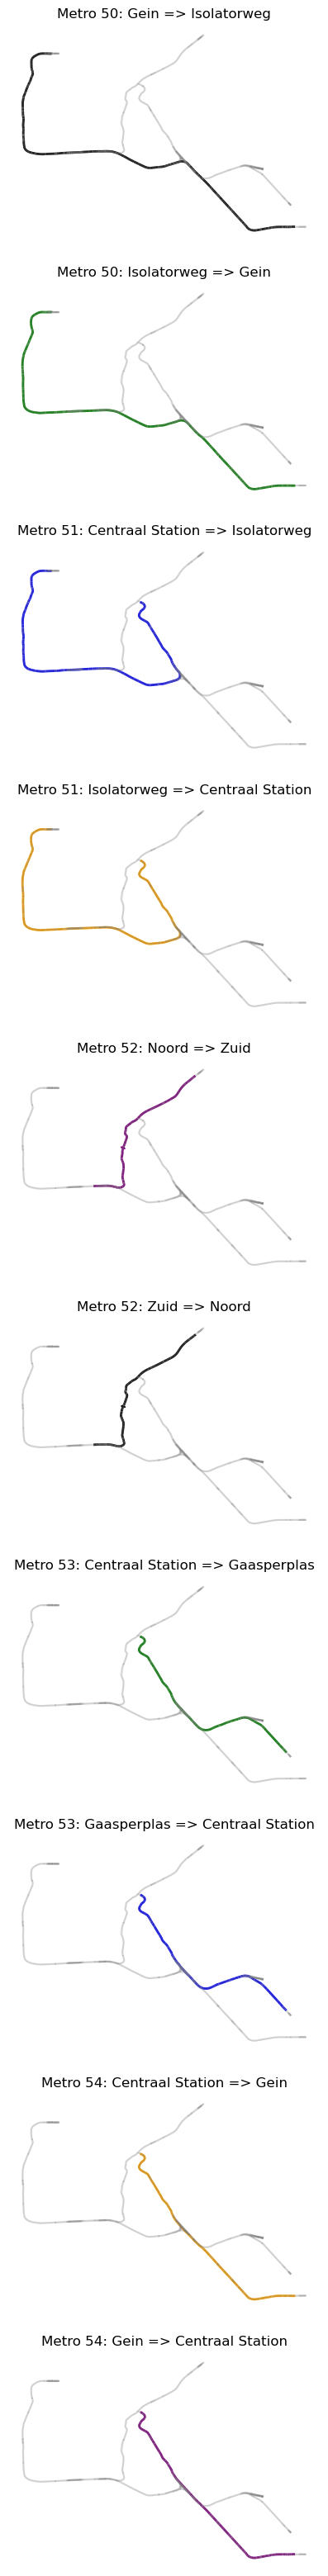

In [12]:
# Create a dictionary mapping subway lines to the pairs of station IDs on each line
city_sub_order_id_pairs = id_pairs_inline(city_sub_line_dict, city_sub_order_route_dict, nodes)

# Create a graph representing the subway network using the extracted edges and nodes
G = create_ground_graph(edges, nodes)

# Calculate the shortest path pairs for each subway line
city_sub_shortest_path_pairs = city_sub_order_id_pairs.copy()
duplicate_row_count = city_sub_order_id_pairs.copy()
city_sub_shortest_path_edges = city_sub_order_id_pairs.copy()
city_sub_edges = city_sub_order_id_pairs.copy()

for line in city_sub_order_id_pairs.keys():
    # Calculate all shortest paths for the current line using the subway network edges
    city_sub_shortest_path_pairs[line] = all_shortest_paths(G, city_sub_order_id_pairs[line], edges)

    # Count the duplicate rows, calculate the weighted edges for shortest paths,
    # and update the subway network edges for the current line
    duplicate_row_count[line], city_sub_shortest_path_edges[line], city_sub_edges[line] = edges_with_count_weight(city_sub_shortest_path_pairs[line], edges)
    sub_edges = city_sub_edges[line]

# # Plot the subway routes with even indices
# plot_routes_even(city_sub_routes, edges, city_sub_shortest_path_edges)

# # Plot the subway routes with odd indices
# plot_routes_odd(city_sub_routes, edges, city_sub_shortest_path_edges)
    
# Plot all subway routes
plot_routes(city_sub_routes, edges, city_sub_shortest_path_edges)

In [13]:
df51_1 = city_sub_shortest_path_edges['Metro 50: Gein => Isolatorweg']
df51_2 = city_sub_shortest_path_edges['Metro 50: Isolatorweg => Gein']

df52_1 = city_sub_shortest_path_edges['Metro 52: Noord => Zuid'] 
df52_2 = city_sub_shortest_path_edges['Metro 52: Zuid => Noord']

df53_1 = city_sub_shortest_path_edges['Metro 53: Centraal Station => Gaasperplas']
df53_2 = city_sub_shortest_path_edges['Metro 53: Gaasperplas => Centraal Station']

df54_1 = city_sub_shortest_path_edges['Metro 54: Centraal Station => Gein']
df54_2 = city_sub_shortest_path_edges['Metro 54: Gein => Centraal Station']

In [14]:
gpd.GeoDataFrame(df51_1[['osm_id', 'geometry','id']]).to_file('df51_1_0229.GPKG',driver='GPKG')
gpd.GeoDataFrame(df51_2[['osm_id', 'geometry','id']]).to_file('df51_2_0229.GPKG',driver='GPKG')
gpd.GeoDataFrame(df52_1[['osm_id', 'geometry','id']]).to_file('df52_1_0229.GPKG',driver='GPKG')
gpd.GeoDataFrame(df52_2[['osm_id', 'geometry','id']]).to_file('df52_2_0229.GPKG',driver='GPKG')
gpd.GeoDataFrame(df53_1[['osm_id', 'geometry','id']]).to_file('df53_1_0229.GPKG',driver='GPKG')
gpd.GeoDataFrame(df53_2[['osm_id', 'geometry','id']]).to_file('df53_2_0229.GPKG',driver='GPKG')
gpd.GeoDataFrame(df54_1[['osm_id', 'geometry','id']]).to_file('df54_1_0229.GPKG',driver='GPKG')
gpd.GeoDataFrame(df54_2[['osm_id', 'geometry','id']]).to_file('df54_2_0229.GPKG',driver='GPKG')

## Add columns to nodes

In [15]:
city_sub_order_route_dict = add_ref_to_orderroutes_or_shortestpath_dict(city_sub_order_route_dict, city_sub_routes)

In [16]:
city_sub_order_route_dict

{'Metro 50: Gein => Isolatorweg':     id                 name                      geometry     geo_x  \
 0    5                 Gein  POINT (4.9891612 52.2964067)  4.989161   
 1   18           Reigersbos  POINT (4.9740002 52.2956365)     4.974   
 2   17          Holendrecht  POINT (4.9601264 52.2981319)  4.960126   
 3    6            Bullewijk   POINT (4.9521292 52.306869)  4.952129   
 4    4        Bijlmer ArenA   POINT (4.9476178 52.311806)  4.947618   
 5    3          Strandvliet  POINT (4.9413977 52.3186119)  4.941398   
 6   16         Duivendrecht  POINT (4.9365601 52.3236024)   4.93656   
 7    7      Van der Madeweg  POINT (4.9304544 52.3297847)  4.930454   
 8    9           Overamstel  POINT (4.9176063 52.3317688)  4.917606   
 9   19          Station RAI    POINT (4.889539 52.337689)  4.889539   
 10  10                 Zuid  POINT (4.8739633 52.3393223)  4.873963   
 11   8      Amstelveenseweg  POINT (4.8575709 52.3384751)  4.857571   
 12  11    Henk Sneevlietweg  P

In [17]:
city_sub_new_nodes = add_columns_to_nodes(city_sub_order_route_dict, nodes)

In [18]:
city_sub_new_nodes

,geometry,degree,id,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer
0,POINT (4.98916 52.29641),2,328,Gein,4.989161,52.296407,"(4.9891612, 52.2964067)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
1,POINT (4.97400 52.29564),2,855,Reigersbos,4.974000,52.295637,"(4.9740002, 52.2956365)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
2,POINT (4.96013 52.29813),2,854,Holendrecht,4.960126,52.298132,"(4.9601264, 52.2981319)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
3,POINT (4.95213 52.30687),2,810,Bullewijk,4.952129,52.306869,"(4.9521292, 52.306869)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
4,POINT (4.94762 52.31181),2,809,Bijlmer ArenA,4.947618,52.311806,"(4.9476178, 52.311806)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
...,...,...,...,...,...,...,...,...,...,...,...
81,POINT (4.96734 52.32837),2,824,Verrijn Stuartweg,4.967335,52.328367,"(4.9673352, 52.3283668)",Metro 53: Gaasperplas => Centraal Station,subway,53,None
82,POINT (4.95669 52.33041),2,823,Station Diemen Zuid,4.956688,52.330406,"(4.9566878, 52.3304057)",Metro 53: Gaasperplas => Centraal Station,subway,53,None
83,POINT (4.94628 52.32683),2,829,Venserpolder,4.946277,52.326833,"(4.9462773, 52.3268326)",Metro 53: Gaasperplas => Centraal Station,subway,53,None
84,POINT (4.93028 52.32974),2,827,Van der Madeweg,4.930285,52.329735,"(4.9302846, 52.3297352)",Metro 53: Gaasperplas => Centraal Station,subway,"50, 53, 54","50, 53, 54"


## Add columns to edges

In [19]:
city_sub_shortest_path_edges = add_ref_to_orderroutes_or_shortestpath_dict(city_sub_shortest_path_edges, city_sub_routes)

In [20]:
city_sub_shortest_path_edges

{'Metro 50: Gein => Isolatorweg':         osm_id                                           geometry railway  \
 0    166187911  LINESTRING (4.9823107 52.2963387, 4.9838859 52...  subway   
 1    166187914  LINESTRING (4.9850607 52.2963027, 4.9855227 52...  subway   
 2    166187917  LINESTRING (4.9871059 52.2963808, 4.9873266 52...  subway   
 3    166187918  LINESTRING (4.9776921 52.2962066, 4.9783293 52...  subway   
 4    166187922  LINESTRING (4.9847395 52.2963009, 4.9850607 52...  subway   
 ..         ...                                                ...     ...   
 165  166370272  LINESTRING (4.8465456 52.3951777, 4.8467329 52...  subway   
 166  166370274  LINESTRING (4.8471465 52.3951789, 4.8471814 52...  subway   
 167  166370274  LINESTRING (4.8471814 52.3951787, 4.8473044 52...  subway   
 168  166370275  LINESTRING (4.8467329 52.3951774, 4.8471465 52...  subway   
 169  166370277  LINESTRING (4.8389786 52.3890375, 4.8389667 52...  subway   
 
     service   id  from_id  t

In [21]:
city_sub_new_edges = add_columns_to_edges(city_sub_shortest_path_edges,edges)

In [22]:
city_sub_new_edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to,count_weight,route_name_list,route,ref
0,23157994,"LINESTRING (4.9236699 52.3361909, 4.9236979 52...",subway,None,0,0,1,258.660599,0.010346,258,"(0, 1)","(1, 0)",1.0,Metro 51: Isolatorweg => Centraal Station,subway,51
1,23158053,"LINESTRING (4.9642294 52.2945339, 4.9644259 52...",subway,None,1,2,3,215.433271,0.008617,215,"(2, 3)","(3, 2)",1.0,Metro 50: Isolatorweg => Gein,subway,"50, 54"
2,23158054,"LINESTRING (4.9622901 52.2955678, 4.9624673 52...",subway,None,2,4,5,121.794737,0.004872,121,"(4, 5)","(5, 4)",1.0,Metro 50: Isolatorweg => Gein,subway,"50, 54"
3,23189033,"LINESTRING (4.8467318 52.3952137, 4.8471439 52...",subway,None,3,6,7,28.046592,0.001122,28,"(6, 7)","(7, 6)",NaN,NaN,NaN,NaN
4,23189039,"LINESTRING (4.8409161 52.3937679, 4.8416087 52...",subway,None,4,8,492,382.935219,0.015317,382,"(8, 492)","(492, 8)",1.0,Metro 50: Isolatorweg => Gein,subway,"50, 51"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,1131538381,"LINESTRING (4.9200955 52.3417374, 4.9200444 52...",subway,None,957,803,463,73.656989,0.002946,73,"(803, 463)","(463, 803)",1.0,Metro 53: Gaasperplas => Centraal Station,subway,"53, 54"
958,1131538382,"LINESTRING (4.9201445 52.3416568, 4.9200955 52...",subway,None,958,462,803,9.568427,0.000383,9,"(462, 803)","(803, 462)",1.0,Metro 53: Gaasperplas => Centraal Station,subway,"53, 54"
959,1131538383,"LINESTRING (4.9200365 52.3417239, 4.9200773 52...",subway,None,959,804,246,9.568874,0.000383,9,"(804, 246)","(246, 804)",1.0,Metro 51: Isolatorweg => Centraal Station,subway,51
960,1131538384,"LINESTRING (4.9197172 52.3423576, 4.9197589 52...",subway,None,960,463,804,73.789113,0.002952,73,"(463, 804)","(804, 463)",1.0,Metro 51: Isolatorweg => Centraal Station,subway,51


In [171]:
column_to_drop = 'count_weight'
city_sub_new_edges = city_sub_new_edges.drop(columns=column_to_drop)

# Tram-Amsterdam

## Generate tram networks

In [23]:
city_tram_stations, edges, nodes, city_tram_routes = prepare_tram(osm_path)

topology: 100%|██████████████████████████████████████████████████████████████████| 2204/2204 [00:00<00:00, 7956.74it/s]


Calculate_degree possibly unhappy


In [24]:
edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to
0,7045610,"LINESTRING (4.9324018 52.3610615, 4.932387 52....",tram,None,0,0,1,28.561299,0.002040,28,"(0, 1)","(1, 0)"
1,7045616,"LINESTRING (4.934085 52.3609657, 4.9340765 52....",tram,None,1,2,3,146.082551,0.010434,146,"(2, 3)","(3, 2)"
2,7045675,"LINESTRING (4.9337809 52.3611734, 4.9339017 52...",tram,None,2,4,5,390.987463,0.027928,390,"(4, 5)","(5, 4)"
3,7045689,"LINESTRING (4.9394 52.361617, 4.9385742 52.361...",tram,None,3,6,7,345.247175,0.024661,345,"(6, 7)","(7, 6)"
4,7045994,"LINESTRING (4.9157261 52.365067, 4.9157046 52....",tram,None,4,8,1730,35.152166,0.002511,35,"(8, 1730)","(1730, 8)"
...,...,...,...,...,...,...,...,...,...,...,...,...
2199,1185084715,"LINESTRING (4.8520736 52.3479443, 4.8521852 52...",tram,None,2199,1496,594,11.280287,0.000806,11,"(1496, 594)","(594, 1496)"
2200,1185084716,"LINESTRING (4.852325 52.3480075, 4.852489 52.3...",tram,None,2200,562,1072,12.010525,0.000858,12,"(562, 1072)","(1072, 562)"
2201,1185084717,"LINESTRING (4.8516012 52.3470208, 4.8519064 52...",tram,None,2201,1497,561,81.765515,0.005840,81,"(1497, 561)","(561, 1497)"
2202,1185084718,"LINESTRING (4.8522982 52.348033, 4.8524709 52....",tram,None,2202,566,1079,12.587379,0.000899,12,"(566, 1079)","(1079, 566)"


In [25]:
nodes

,geometry,degree,id
0,POINT (4.9324018 52.3610615),3,0
1,POINT (4.9321097 52.361227),3,1
2,POINT (4.934085 52.3609657),3,2
3,POINT (4.933017 52.3603624),3,3
4,POINT (4.9337809 52.3611734),3,4
...,...,...,...
1915,POINT (4.9009826 52.3777045),0,1915
1916,POINT (4.890644 52.3719008),2,1916
1917,POINT (4.9899502 52.3580579),2,1917
1918,POINT (4.9272548 52.357015),0,1918


In [26]:
city_tram_routes

,osm_id,route,to,name,ref,network,service,geometry
17,31398,tram,"Amsterdam, De Boelelaan/VU",Tram 24: Amsterdam Centraal Station => Amsterd...,24,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.89406 52.37387, 4.89361 52..."
18,31530,tram,"Amsterdam, Oudenaardeplantsoen",Tram 2: Amsterdam Centraal Station => Amsterda...,2,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.81102 52.34641, 4.81118 52..."
19,31794,tram,"Amsterdam, Drentepark",Tram 4: Amsterdam Centraal Station => Amsterda...,4,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.89406 52.37387, 4.89361 52..."
22,32579,tram,"Amsterdam, Osdorp Dijkgraafsplein",Tram 17: Amsterdam Centraal Station => Amsterd...,17,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.89915 52.37828, 4.89919 52..."
23,32615,tram,"Amsterdam, IJburg",Tram 26: Amsterdam Centraal Station => Amsterd...,26,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.90035 52.37793, 4.90035 52..."
24,32867,tram,"Amsterdam, Lambertus Zijlplein",Tram 13: Amsterdam Centraal Station => Amsterd...,13,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.89922 52.37830, 4.89926 52..."
390,4494870,tram,"Amsterdam, Centraal Station",Tram 4: Amsterdam Station RAI => Amsterdam Cen...,4,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.88956 52.33608, 4.88962 52..."
391,4497721,tram,"Amsterdam, Centraal Station",Tram 2: Amsterdam Nieuw Sloten => Amsterdam Ce...,2,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.80985 52.34614, 4.81032 52..."
392,4512710,tram,Amsterdam Centraal Station,Tram 13: Amsterdam Geuzenveld => Amsterdam Cen...,13,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.80291 52.37726, 4.80320 52..."
393,4513899,tram,"Amsterdam, Centraal Station",Tram 24: Amsterdam VUmc => Amsterdam Centraal ...,24,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.86582 52.33525, 4.86638 52..."


In [27]:
len(city_tram_routes)

30

In [28]:
city_tram_routes = city_tram_routes.loc[city_tram_routes.ref != 'EMA']

In [29]:
city_tram_routes, check_name = check_tram_routes(city_tram_stations, city_tram_routes)

In [30]:
replacement_dict = {
    ',': '',
    'Diemen': '',
    'Amsterdam': '',
    'Sloterdijk': 'Station Sloterdijk',
    'Osdorp Dijkgraafsplein': 'Dijkgraafplein',
    'Osdorp De Aker': 'Matterhorn'
}

city_tram_stations, city_tram_routes, check_name = recheck_tram_routes(replacement_dict, city_tram_stations, city_tram_routes)

In [31]:
replacement_dict = {
    'Amstelveen Westwijk': 'Westwijk'
}

city_tram_stations, city_tram_routes, check_name = recheck_tram_routes(replacement_dict, city_tram_stations, city_tram_routes)

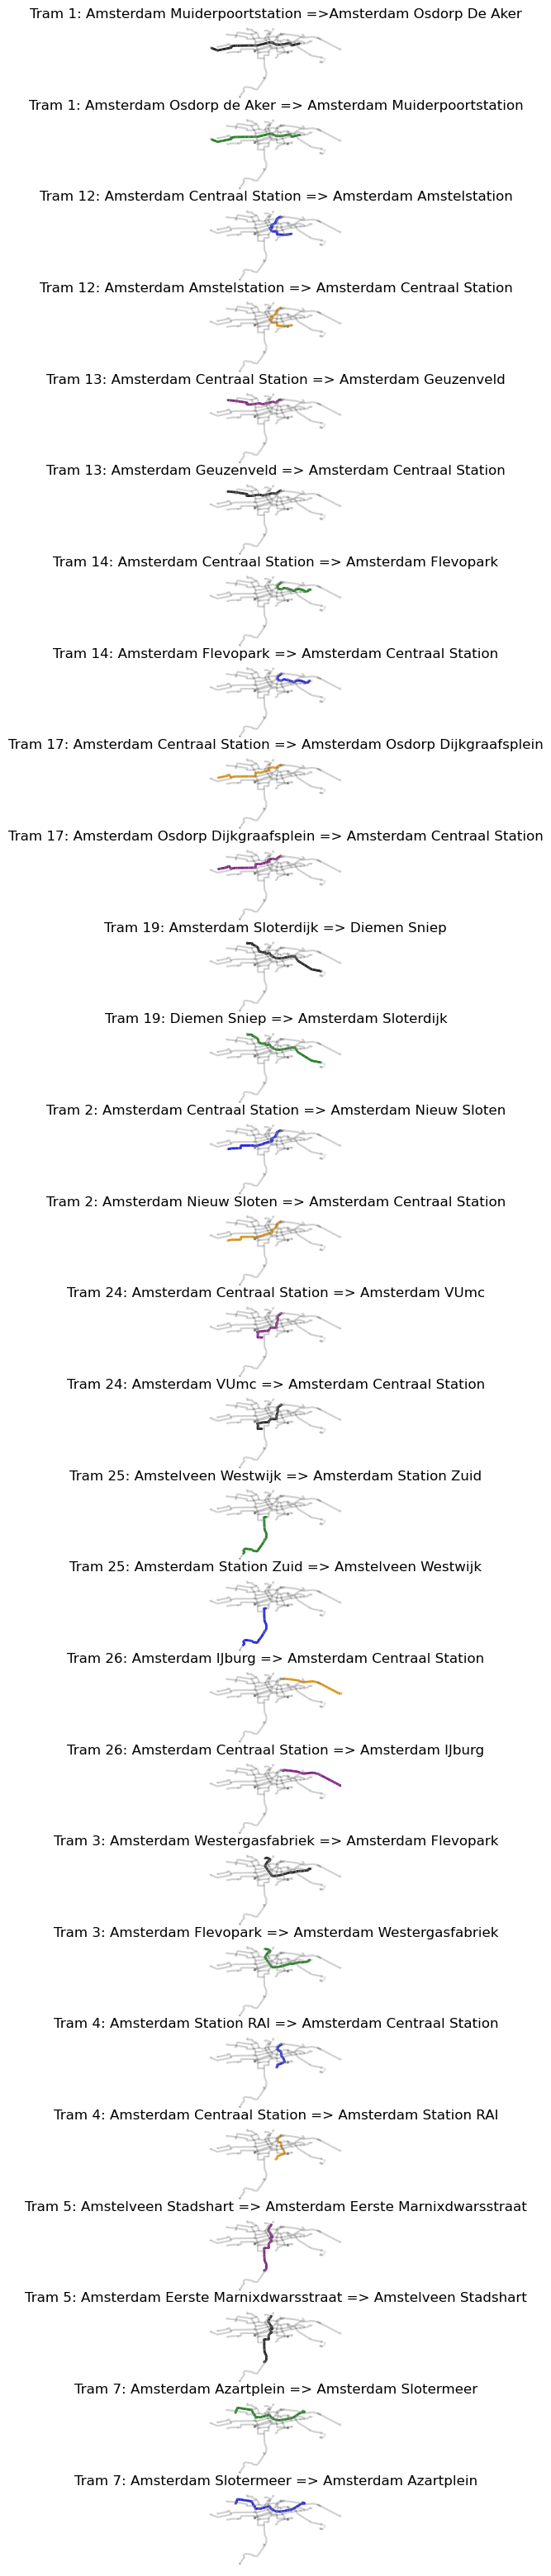

In [32]:
city_tram_order_route_dict, city_tram_shortest_path_pairs, city_tram_shortest_path_edges, tram_edges = tram(city_tram_stations, edges, nodes, city_tram_routes, city='Amsterdam')

In [33]:
tram_edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to
0,7045610,"LINESTRING (4.9324018 52.3610615, 4.932387 52....",tram,None,0,0,1,28.561299,0.002040,28,"(0, 1)","(1, 0)"
1,7045616,"LINESTRING (4.934085 52.3609657, 4.9340765 52....",tram,None,1,2,3,146.082551,0.010434,146,"(2, 3)","(3, 2)"
2,7045675,"LINESTRING (4.9337809 52.3611734, 4.9339017 52...",tram,None,2,4,5,390.987463,0.027928,390,"(4, 5)","(5, 4)"
3,7045689,"LINESTRING (4.9394 52.361617, 4.9385742 52.361...",tram,None,3,6,7,345.247175,0.024661,345,"(6, 7)","(7, 6)"
4,7045994,"LINESTRING (4.9157261 52.365067, 4.9157046 52....",tram,None,4,8,1730,35.152166,0.002511,35,"(8, 1730)","(1730, 8)"
...,...,...,...,...,...,...,...,...,...,...,...,...
2199,1185084715,"LINESTRING (4.8520736 52.3479443, 4.8521852 52...",tram,None,2199,1496,594,11.280287,0.000806,11,"(1496, 594)","(594, 1496)"
2200,1185084716,"LINESTRING (4.852325 52.3480075, 4.852489 52.3...",tram,None,2200,562,1072,12.010525,0.000858,12,"(562, 1072)","(1072, 562)"
2201,1185084717,"LINESTRING (4.8516012 52.3470208, 4.8519064 52...",tram,None,2201,1497,561,81.765515,0.005840,81,"(1497, 561)","(561, 1497)"
2202,1185084718,"LINESTRING (4.8522982 52.348033, 4.8524709 52....",tram,None,2202,566,1079,12.587379,0.000899,12,"(566, 1079)","(1079, 566)"


## Add columns to nodes

In [34]:
city_tram_order_route_dict = add_ref_to_orderroutes_or_shortestpath_dict(city_tram_order_route_dict, city_tram_routes)

In [35]:
city_tram_order_route_dict

{'Tram 1: Amsterdam Muiderpoortstation =>Amsterdam Osdorp De Aker':     id                              name                      geometry  \
 0   21                Muiderpoortstation  POINT (4.9326128 52.3607965)   
 1    0                      Dapperstraat  POINT (4.9289422 52.3609314)   
 2    6                    Linnaeusstraat  POINT (4.9257029 52.3601162)   
 3    7                         Beukenweg  POINT (4.9167422 52.3590732)   
 4    4         Korte 's-Gravesandestraat  POINT (4.9135923 52.3623479)   
 5    3                      Weesperplein  POINT (4.9071213 52.3610021)   
 6   22                    Frederiksplein  POINT (4.8978483 52.3594109)   
 7    5                      Vijzelgracht  POINT (4.8921024 52.3595051)   
 8    1                       Rijksmuseum   POINT (4.887104 52.3609734)   
 9   23                       Leidseplein  POINT (4.8810698 52.3632085)   
 10  13  Eerste Constantijn Huygensstraat  POINT (4.8747145 52.3626163)   
 11  24            Jan Pieter Hei

In [36]:
city_tram_new_nodes = add_columns_to_nodes(city_tram_order_route_dict, nodes)

In [37]:
city_tram_new_nodes

,geometry,degree,id,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer
0,POINT (4.93261 52.36080),2,1341,Muiderpoortstation,4.932613,52.360796,"(4.9326128, 52.3607965)",Tram 1: Amsterdam Muiderpoortstation =>Amsterd...,tram,"1, 3","1, 3"
1,POINT (4.92894 52.36093),2,1503,Dapperstraat,4.928942,52.360931,"(4.9289422, 52.3609314)",Tram 1: Amsterdam Muiderpoortstation =>Amsterd...,tram,"1, 3","1, 3"
2,POINT (4.92570 52.36012),2,1606,Linnaeusstraat,4.925703,52.360116,"(4.9257029, 52.3601162)",Tram 1: Amsterdam Muiderpoortstation =>Amsterd...,tram,"1, 3","1, 3"
3,POINT (4.91674 52.35907),2,1612,Beukenweg,4.916742,52.359073,"(4.9167422, 52.3590732)",Tram 1: Amsterdam Muiderpoortstation =>Amsterd...,tram,"1, 3","1, 3"
4,POINT (4.91359 52.36235),2,1598,Korte 's-Gravesandestraat,4.913592,52.362348,"(4.9135923, 52.3623479)",Tram 1: Amsterdam Muiderpoortstation =>Amsterd...,tram,"1, 19, 7","1, 19, 7"
...,...,...,...,...,...,...,...,...,...,...,...
413,POINT (4.92630 52.36814),2,1559,Eerste Coehoornstraat,4.926300,52.368143,"(4.9263002, 52.3681426)",Tram 7: Amsterdam Slotermeer => Amsterdam Azar...,tram,7,None
414,POINT (4.92960 52.37020),2,1808,Eerste Leeghwaterstraat,4.929600,52.370198,"(4.9295997, 52.3701978)",Tram 7: Amsterdam Slotermeer => Amsterdam Azar...,tram,7,None
415,POINT (4.93483 52.37301),2,1515,Rietlandpark,4.934833,52.373011,"(4.9348327, 52.3730107)",Tram 7: Amsterdam Slotermeer => Amsterdam Azar...,tram,"26, 7","26, 7"
416,POINT (4.93817 52.37346),2,1751,C. van Eesterenlaan,4.938170,52.373460,"(4.9381702, 52.3734596)",Tram 7: Amsterdam Slotermeer => Amsterdam Azar...,tram,7,None


In [38]:
# city_tram_new_nodes.to_excel('./city_tram_new_nodes11.xlsx',header = True, index = False)

### retrive all transfer stations on each route

In [39]:
city_tram_transfer_stations_df = all_transfer_stations_df(city_tram_new_nodes)

In [40]:
city_tram_transfer_stations_df

,geometry,degree,id,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer
0,POINT (4.93261 52.36080),2,1341,Muiderpoortstation,4.932613,52.360796,"(4.9326128, 52.3607965)",Tram 1: Amsterdam Muiderpoortstation =>Amsterd...,tram,"1, 3","1, 3"
1,POINT (4.92894 52.36093),2,1503,Dapperstraat,4.928942,52.360931,"(4.9289422, 52.3609314)",Tram 1: Amsterdam Muiderpoortstation =>Amsterd...,tram,"1, 3","1, 3"
2,POINT (4.92570 52.36012),2,1606,Linnaeusstraat,4.925703,52.360116,"(4.9257029, 52.3601162)",Tram 1: Amsterdam Muiderpoortstation =>Amsterd...,tram,"1, 3","1, 3"
3,POINT (4.91674 52.35907),2,1612,Beukenweg,4.916742,52.359073,"(4.9167422, 52.3590732)",Tram 1: Amsterdam Muiderpoortstation =>Amsterd...,tram,"1, 3","1, 3"
4,POINT (4.91359 52.36235),2,1598,Korte 's-Gravesandestraat,4.913592,52.362348,"(4.9135923, 52.3623479)",Tram 1: Amsterdam Muiderpoortstation =>Amsterd...,tram,"1, 19, 7","1, 19, 7"
...,...,...,...,...,...,...,...,...,...,...,...
393,POINT (4.84859 52.37333),2,1642,Jan van Galenstraat,4.848589,52.373332,"(4.8485891, 52.3733319)",Tram 7: Amsterdam Azartplein => Amsterdam Slot...,tram,"13, 19, 7","13, 19, 7"
408,POINT (4.84872 52.37298),2,1802,Jan van Galenstraat,4.848724,52.372983,"(4.8487242, 52.3729826)",Tram 7: Amsterdam Slotermeer => Amsterdam Azar...,tram,"13, 19, 7","13, 19, 7"
409,POINT (4.85007 52.37041),2,1888,Mercatorplein,4.850068,52.370406,"(4.8500681, 52.3704058)",Tram 7: Amsterdam Slotermeer => Amsterdam Azar...,tram,"13, 7","13, 7"
411,POINT (4.91857 52.36337),2,1803,Alexanderplein,4.918568,52.363371,"(4.9185684, 52.3633708)",Tram 7: Amsterdam Slotermeer => Amsterdam Azar...,tram,"14, 19, 7","14, 19, 7"


In [41]:
len(city_tram_transfer_stations_df)

183

## Add columns to edges

In [42]:
city_tram_shortest_path_edges = add_ref_to_orderroutes_or_shortestpath_dict(city_tram_shortest_path_edges, city_tram_routes)

In [43]:
city_tram_shortest_path_edges

{'Tram 1: Amsterdam Muiderpoortstation =>Amsterdam Osdorp De Aker':        osm_id                                           geometry railway  \
 0     7045610  LINESTRING (4.9324018 52.3610615, 4.932387 52....    tram   
 1   770429442  LINESTRING (4.9326128 52.3607965, 4.9325204 52...    tram   
 2   770429442  LINESTRING (4.9325122 52.3609243, 4.9324018 52...    tram   
 3   770438581  LINESTRING (4.9321097 52.361227, 4.9305569 52....    tram   
 4   770438581  LINESTRING (4.9289422 52.3609314, 4.9288413 52...    tram   
 ..        ...                                                ...     ...   
 91   26594761  LINESTRING (4.785218 52.3495798, 4.7849725 52....    tram   
 92  322841907  LINESTRING (4.7881565 52.3496994, 4.7880725 52...    tram   
 93  322841927  LINESTRING (4.7849725 52.3496771, 4.7836582 52...    tram   
 94  322841927  LINESTRING (4.7836582 52.3501979, 4.7833776 52...    tram   
 95  322841927  LINESTRING (4.7770976 52.352828, 4.7768625 52....    tram   
 
    ser

In [44]:
city_tram_new_edges = add_columns_to_edges(city_tram_shortest_path_edges,edges)

In [45]:
city_tram_new_edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to,count_weight,route_name_list,route,ref
0,7045610,"LINESTRING (4.9324018 52.3610615, 4.932387 52....",tram,None,0,0,1,28.561299,0.002040,28,"(0, 1)","(1, 0)",1.0,Tram 1: Amsterdam Muiderpoortstation =>Amsterd...,tram,1
1,7045616,"LINESTRING (4.934085 52.3609657, 4.9340765 52....",tram,None,1,2,3,146.082551,0.010434,146,"(2, 3)","(3, 2)",NaN,NaN,NaN,NaN
2,7045675,"LINESTRING (4.9337809 52.3611734, 4.9339017 52...",tram,None,2,4,5,390.987463,0.027928,390,"(4, 5)","(5, 4)",1.0,Tram 3: Amsterdam Westergasfabriek => Amsterda...,tram,3
3,7045689,"LINESTRING (4.9394 52.361617, 4.9385742 52.361...",tram,None,3,6,7,345.247175,0.024661,345,"(6, 7)","(7, 6)",1.0,Tram 3: Amsterdam Flevopark => Amsterdam Weste...,tram,3
4,7045994,"LINESTRING (4.9157261 52.365067, 4.9157046 52....",tram,None,4,8,1730,35.152166,0.002511,35,"(8, 1730)","(1730, 8)",1.0,Tram 14: Amsterdam Flevopark => Amsterdam Cent...,tram,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,1185084715,"LINESTRING (4.8520736 52.3479443, 4.8521852 52...",tram,None,2199,1496,594,11.280287,0.000806,11,"(1496, 594)","(594, 1496)",NaN,NaN,NaN,NaN
2200,1185084716,"LINESTRING (4.852325 52.3480075, 4.852489 52.3...",tram,None,2200,562,1072,12.010525,0.000858,12,"(562, 1072)","(1072, 562)",NaN,NaN,NaN,NaN
2201,1185084717,"LINESTRING (4.8516012 52.3470208, 4.8519064 52...",tram,None,2201,1497,561,81.765515,0.005840,81,"(1497, 561)","(561, 1497)",NaN,NaN,NaN,NaN
2202,1185084718,"LINESTRING (4.8522982 52.348033, 4.8524709 52....",tram,None,2202,566,1079,12.587379,0.000899,12,"(566, 1079)","(1079, 566)",NaN,NaN,NaN,NaN


# Bus-Amsterdam

## Generate bus networks

In [46]:
city_bus_stations, edges, nodes, city_bus_routes = prepare_bus(osm_path)

topology: 100%|████████████████████████████████████████████████████████████████| 71634/71634 [00:08<00:00, 8544.55it/s]


In [47]:
edges

,osm_id,geometry,service,id,from_id,to_id,distance,time,weights,to_from,from_to,railway
0,4436684,"LINESTRING (4.9683596 52.3558775, 4.9683345 52...",steps,0,0,1,4.049164,0.000324,4,"(0, 1)","(1, 0)",bus
1,4495957,"LINESTRING (4.8601784 52.357593, 4.8601399 52....",steps,1,2,3,7.754968,0.000620,7,"(2, 3)","(3, 2)",bus
2,4496429,"LINESTRING (4.8743983 52.358788, 4.8744747 52....",service,2,4,5,68.807947,0.005505,68,"(4, 5)","(5, 4)",bus
3,4727308,"LINESTRING (4.9563878 52.377293, 4.9564629 52....",path,3,6,65237,46.383298,0.003711,46,"(6, 65237)","(65237, 6)",bus
4,4727308,"LINESTRING (4.9564856 52.376881, 4.9564944 52....",path,4,65237,7,2.090290,0.000167,2,"(65237, 7)","(7, 65237)",bus
...,...,...,...,...,...,...,...,...,...,...,...,...
71623,1185077512,"LINESTRING (4.795149 52.3318873, 4.7953163 52....",service,71623,65586,65587,29.884042,0.002391,29,"(65586, 65587)","(65587, 65586)",bus
71624,1185077519,"LINESTRING (4.7974835 52.3325307, 4.7972201 52...",service,71624,65588,65589,19.267219,0.001541,19,"(65588, 65589)","(65589, 65588)",bus
71625,1185077520,"LINESTRING (4.7967795 52.3323057, 4.7972519 52...",service,71625,65590,65591,34.723141,0.002778,34,"(65590, 65591)","(65591, 65590)",bus
71626,1185077524,"LINESTRING (4.7997017 52.3324389, 4.7997688 52...",path,71626,65592,65593,65.462451,0.005237,65,"(65592, 65593)","(65593, 65592)",bus


In [48]:
nodes

,geometry,degree,id
0,POINT (4.9683596 52.3558775),1,0
1,POINT (4.9683118 52.3558559),1,1
2,POINT (4.8601784 52.357593),1,2
3,POINT (4.8601399 52.3576586),1,3
4,POINT (4.8743983 52.358788),1,4
...,...,...,...
68437,POINT (4.8808204 52.3586774),0,68437
68438,POINT (4.8688259 52.3392455),2,68438
68439,POINT (4.8690257 52.3316423),2,68439
68440,POINT (4.8705297 52.3165252),2,68440


In [49]:
city_bus_routes

,osm_id,route,to,name,ref,network,service,geometry
31,73789,bus,Amsterdam Muiderpoortstation,Bus 40: Amsterdam Amstelstation => Amsterdam M...,40,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.91869 52.34617, 4.91868 52..."
37,146350,bus,"Schiphol, Airport/Plaza",Bus 365: Leiden Centraal Station => Schiphol A...,365,Zuid-Holland Noord,None,"MULTILINESTRING ((4.76218 52.30830, 4.76200 52..."
44,156123,bus,Marken Minneweg,Bus 315: Amsterdam Station Noord => Marken Min...,315,Waterland,None,"MULTILINESTRING ((4.93321 52.40187, 4.93311 52..."
52,161790,bus,"Nieuw Vennep, P+R Getsewoud Zuid",Bus 397: Amsterdam Busstation Elandsgracht → N...,397,Amstelland-Meerlanden,None,"MULTILINESTRING ((4.87678 52.36968, 4.87687 52..."
91,169215,bus,"Haarlem, Station",Bus 300: Amsterdam Bijlmer ArenA → Haarlem Sta...,300,Amstelland-Meerlanden,None,"MULTILINESTRING ((4.94705 52.31143, 4.94711 52..."
...,...,...,...,...,...,...,...,...
1446,13630218,bus,"Amsterdam, Station Noord",Bus 292: Zaandam De Vlinder => Amsterdam Stati...,292,Zaanstreek,None,"MULTILINESTRING ((4.85659 52.42963, 4.85664 52..."
1447,13631642,bus,"Assendelft, Festina Lente",Bus 63: Zaandam Station => Assendelft Festina ...,63,Zaanstreek,None,"MULTILINESTRING ((4.81643 52.43588, 4.81651 52..."
1448,13633193,bus,"Zaandam, Station",Bus 63: Assendelft Festina Lente => Zaandam St...,63,Zaanstreek,None,"MULTILINESTRING ((4.81436 52.43590, 4.81452 52..."
1470,14979096,bus,"Amsterdam, Station Bijlmer ArenA",Bus 330: Almere Station Buiten => Amsterdam St...,330,Busvervoer Almere,None,"MULTILINESTRING ((5.05775 52.32570, 5.05723 52..."


In [50]:
len(city_bus_routes)

319

In [51]:
city_bus_routes = city_bus_routes.loc[city_bus_routes.network == 'Stadsvervoer Amsterdam']
city_bus_routes = city_bus_routes.loc[city_bus_routes.service != 'night']

In [52]:
city_bus_routes, check_name = check_bus_routes(city_bus_stations, city_bus_routes)

In [53]:
replacement_dict = {
    'Amsterdam, ': '',
    'Amsterdam': '',
    'Weesp Station': 'Station',
    'Osdorp De Aker': 'Matterhorn',
    'Schiphol, Airport/Plaza': 'Schiphol, Airport',
    'De Boelelaan': 'De Boelelaan/De Klencke'
}
replacement_dict1 = {
    'Amsterdam, ': '',
    'Amsterdam': '',
}

city_bus_stations['name'] = city_bus_stations['name'].replace(replacement_dict1, regex=True).str.strip()

city_bus_stations, city_bus_routes, check_name = recheck_bus_routes(replacement_dict, city_bus_stations, city_bus_routes)

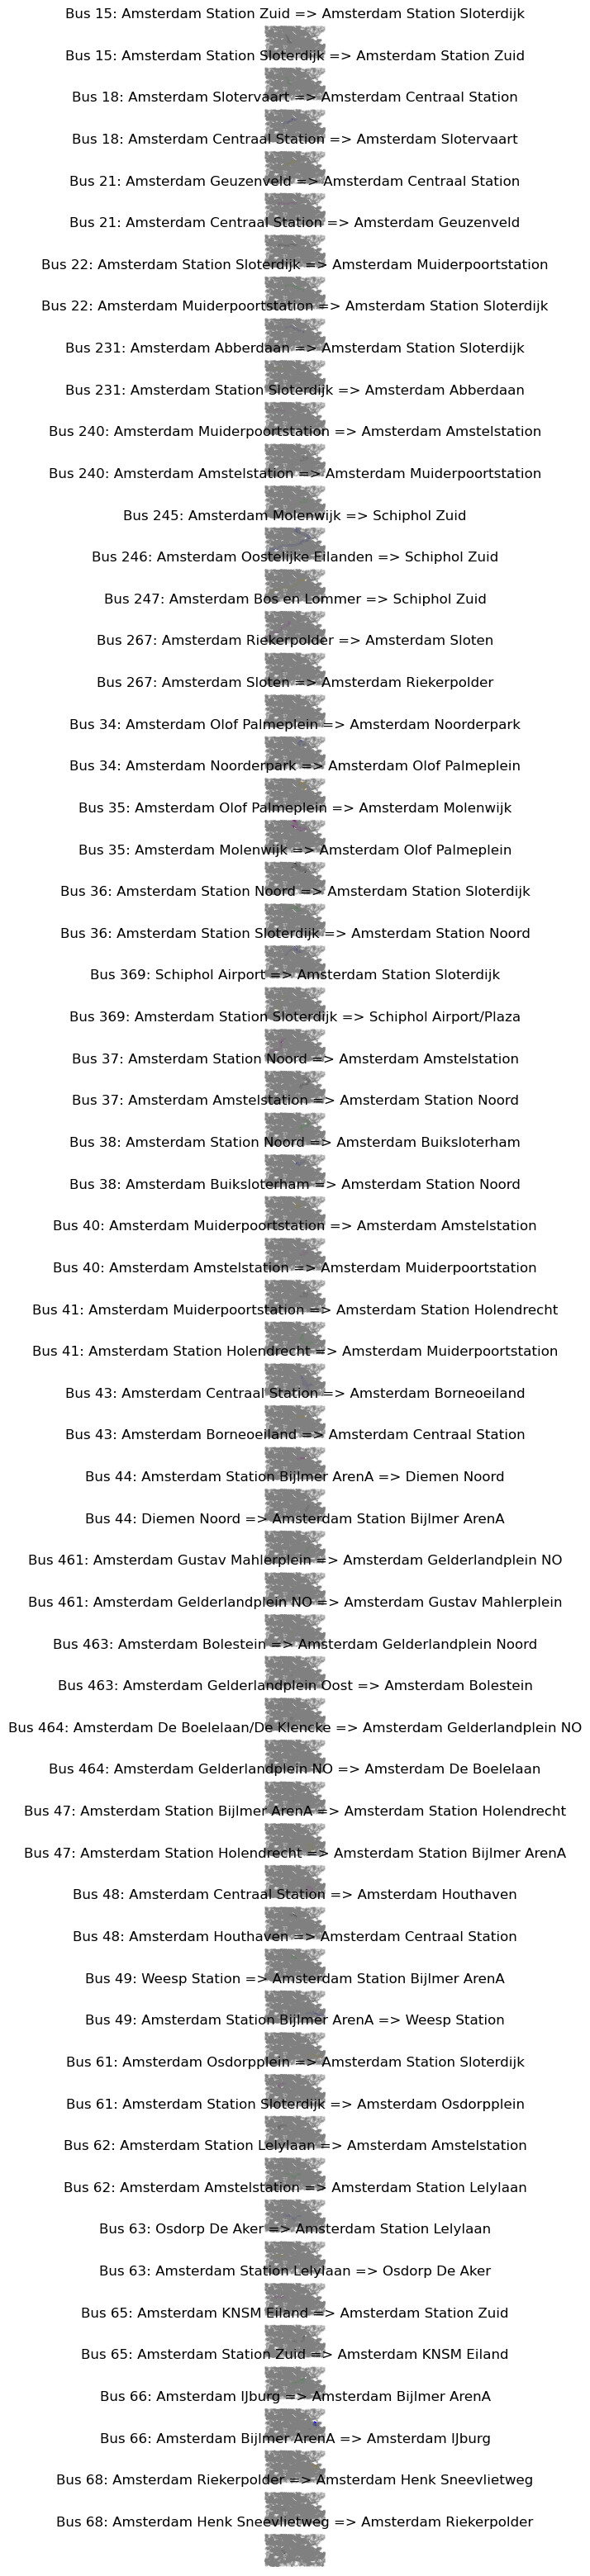

In [54]:
city_bus_order_route_dict, city_bus_shortest_path_pairs, city_bus_shortest_path_edges, bus_edges = bus(city_bus_stations, edges, nodes, city_bus_routes, city='Amsterdam')

In [55]:
city_bus_order_route_dict

{'Bus 15: Amsterdam Station Zuid => Amsterdam Station Sloterdijk':     id                   name                      geometry     geo_x  \
 0    6           Station Zuid  POINT (4.8720355 52.3408188)  4.872035   
 1    3    Prinses Irenestraat  POINT (4.8682898 52.3428941)   4.86829   
 2   10           Olympiaplein   POINT (4.865862 52.3462864)  4.865862   
 3    8             Olympiaweg  POINT (4.8583469 52.3452468)  4.858347   
 4   28  Haarlemmermeerstation  POINT (4.8576315 52.3492179)  4.857632   
 5   22             Zeilstraat  POINT (4.8566667 52.3512098)  4.856667   
 6   21        Amstelveenseweg  POINT (4.8560722 52.3513667)  4.856072   
 7    1         Hoofddorpplein  POINT (4.8503895 52.3520264)   4.85039   
 8   20   Haarlemmermeerstraat  POINT (4.8503138 52.3554125)  4.850314   
 9   23          Surinameplein  POINT (4.8521842 52.3580689)  4.852184   
 10  26        Corantijnstraat  POINT (4.8532685 52.3617315)  4.853269   
 11  24             Postjesweg    POINT (4.853

## Add columns to nodes

In [56]:
city_bus_order_route_dict = add_ref_to_orderroutes_or_shortestpath_dict(city_bus_order_route_dict, city_bus_routes)

In [57]:
city_bus_order_route_dict

{'Bus 15: Amsterdam Station Zuid => Amsterdam Station Sloterdijk':     id                   name                      geometry     geo_x  \
 0    6           Station Zuid  POINT (4.8720355 52.3408188)  4.872035   
 1    3    Prinses Irenestraat  POINT (4.8682898 52.3428941)   4.86829   
 2   10           Olympiaplein   POINT (4.865862 52.3462864)  4.865862   
 3    8             Olympiaweg  POINT (4.8583469 52.3452468)  4.858347   
 4   28  Haarlemmermeerstation  POINT (4.8576315 52.3492179)  4.857632   
 5   22             Zeilstraat  POINT (4.8566667 52.3512098)  4.856667   
 6   21        Amstelveenseweg  POINT (4.8560722 52.3513667)  4.856072   
 7    1         Hoofddorpplein  POINT (4.8503895 52.3520264)   4.85039   
 8   20   Haarlemmermeerstraat  POINT (4.8503138 52.3554125)  4.850314   
 9   23          Surinameplein  POINT (4.8521842 52.3580689)  4.852184   
 10  26        Corantijnstraat  POINT (4.8532685 52.3617315)  4.853269   
 11  24             Postjesweg    POINT (4.853

In [58]:
city_bus_new_nodes = add_columns_to_nodes(city_bus_order_route_dict, nodes)

In [59]:
city_bus_new_nodes

,geometry,degree,id,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer
0,POINT (4.87204 52.34082),2,14779,Station Zuid,4.872035,52.340819,"(4.8720355, 52.3408188)",Bus 15: Amsterdam Station Zuid => Amsterdam St...,bus,"15, 62, 65","15, 62, 65"
1,POINT (4.86829 52.34289),2,67476,Prinses Irenestraat,4.868290,52.342894,"(4.8682898, 52.3428941)",Bus 15: Amsterdam Station Zuid => Amsterdam St...,bus,"15, 246, 65","15, 246, 65"
2,POINT (4.86586 52.34629),2,68204,Olympiaplein,4.865862,52.346286,"(4.865862, 52.3462864)",Bus 15: Amsterdam Station Zuid => Amsterdam St...,bus,15,None
3,POINT (4.85835 52.34525),2,68196,Olympiaweg,4.858347,52.345247,"(4.8583469, 52.3452468)",Bus 15: Amsterdam Station Zuid => Amsterdam St...,bus,15,None
4,POINT (4.85763 52.34922),2,68341,Haarlemmermeerstation,4.857632,52.349218,"(4.8576315, 52.3492179)",Bus 15: Amsterdam Station Zuid => Amsterdam St...,bus,"15, 62","15, 62"
...,...,...,...,...,...,...,...,...,...,...,...
752,POINT (4.99474 52.35561),2,67471,Diemerparklaan,4.994741,52.355608,"(4.9947414, 52.355608)",Bus 66: Amsterdam Bijlmer ArenA => Amsterdam I...,bus,66,None
753,POINT (4.82444 52.34041),3,15699,John M. Keynesplein,4.824444,52.340413,"(4.824444, 52.340413)",Bus 68: Amsterdam Riekerpolder => Amsterdam He...,bus,"267, 68","267, 68"
754,POINT (4.82789 52.34108),2,11244,IBM,4.827888,52.341080,"(4.827888, 52.3410803)",Bus 68: Amsterdam Riekerpolder => Amsterdam He...,bus,"267, 68","267, 68"
755,POINT (4.82867 52.34260),3,26843,Parkeerdek,4.828668,52.342595,"(4.8286682, 52.3425954)",Bus 68: Amsterdam Riekerpolder => Amsterdam He...,bus,68,None


### retrive all transfer stations on each route

In [60]:
city_bus_transfer_stations_df = all_transfer_stations_df(city_bus_new_nodes)

In [61]:
city_bus_transfer_stations_df

,geometry,degree,id,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer
0,POINT (4.87204 52.34082),2,14779,Station Zuid,4.872035,52.340819,"(4.8720355, 52.3408188)",Bus 15: Amsterdam Station Zuid => Amsterdam St...,bus,"15, 62, 65","15, 62, 65"
1,POINT (4.86829 52.34289),2,67476,Prinses Irenestraat,4.868290,52.342894,"(4.8682898, 52.3428941)",Bus 15: Amsterdam Station Zuid => Amsterdam St...,bus,"15, 246, 65","15, 246, 65"
4,POINT (4.85763 52.34922),2,68341,Haarlemmermeerstation,4.857632,52.349218,"(4.8576315, 52.3492179)",Bus 15: Amsterdam Station Zuid => Amsterdam St...,bus,"15, 62","15, 62"
5,POINT (4.85667 52.35121),2,68268,Zeilstraat,4.856667,52.351210,"(4.8566667, 52.3512098)",Bus 15: Amsterdam Station Zuid => Amsterdam St...,bus,"15, 62","15, 62"
6,POINT (4.85607 52.35137),2,68266,Amstelveenseweg,4.856072,52.351367,"(4.8560722, 52.3513667)",Bus 15: Amsterdam Station Zuid => Amsterdam St...,bus,"15, 246, 62","15, 246, 62"
...,...,...,...,...,...,...,...,...,...,...,...
740,POINT (4.96581 52.31983),0,66747,Tulastraat,4.965810,52.319830,"(4.96581, 52.3198302)",Bus 66: Amsterdam Bijlmer ArenA => Amsterdam I...,bus,"41, 47, 66","41, 47, 66"
741,POINT (4.97152 52.32169),0,67123,Annie Romeinplein,4.971517,52.321685,"(4.9715166, 52.3216851)",Bus 66: Amsterdam Bijlmer ArenA => Amsterdam I...,bus,"41, 66","41, 66"
742,POINT (4.97323 52.32306),2,67461,Station Ganzenhoef,4.973228,52.323056,"(4.9732278, 52.323056)",Bus 66: Amsterdam Bijlmer ArenA => Amsterdam I...,bus,"41, 66","41, 66"
753,POINT (4.82444 52.34041),3,15699,John M. Keynesplein,4.824444,52.340413,"(4.824444, 52.340413)",Bus 68: Amsterdam Riekerpolder => Amsterdam He...,bus,"267, 68","267, 68"


## Add columns to edges

In [62]:
city_bus_shortest_path_edges = add_ref_to_orderroutes_or_shortestpath_dict(city_bus_shortest_path_edges, city_bus_routes)

In [63]:
city_bus_shortest_path_edges

{'Bus 15: Amsterdam Station Zuid => Amsterdam Station Sloterdijk':          osm_id                                           geometry  \
 0      26956728  LINESTRING (4.8720355 52.3408188, 4.8717707 52...   
 1      26956728  LINESTRING (4.8717707 52.3408097, 4.8716246 52...   
 2      26956728  LINESTRING (4.8705601 52.3407731, 4.8702988 52...   
 3      26956728  LINESTRING (4.8702988 52.3407626, 4.868856 52....   
 4      26982261  LINESTRING (4.8685173 52.3409372, 4.8684681 52...   
 ..          ...                                                ...   
 123   935010194  LINESTRING (4.8435054 52.3848361, 4.8436903 52...   
 124  1020818639  LINESTRING (4.8438138 52.3847277, 4.8438383 52...   
 125  1020818640  LINESTRING (4.8428612 52.3848254, 4.8435054 52...   
 126  1020818641  LINESTRING (4.8438898 52.3843611, 4.8439048 52...   
 127  1147115688  LINESTRING (4.8438493 52.3844829, 4.8438898 52...   
 
            service     id  from_id  to_id    distance      time  weights  \
 0 

In [64]:
city_bus_new_edges = add_columns_to_edges(city_bus_shortest_path_edges,edges)

In [65]:
city_bus_new_edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to,count_weight,route_name_list,route,ref
0,4436684,"LINESTRING (4.9683596 52.3558775, 4.9683345 52...",bus,steps,0,0,1,4.049164,0.000324,4,"(0, 1)","(1, 0)",NaN,NaN,NaN,NaN
1,4495957,"LINESTRING (4.8601784 52.357593, 4.8601399 52....",bus,steps,1,2,3,7.754968,0.000620,7,"(2, 3)","(3, 2)",NaN,NaN,NaN,NaN
2,4496429,"LINESTRING (4.8743983 52.358788, 4.8744747 52....",bus,service,2,4,5,68.807947,0.005505,68,"(4, 5)","(5, 4)",NaN,NaN,NaN,NaN
3,4727308,"LINESTRING (4.9563878 52.377293, 4.9564629 52....",bus,path,3,6,65237,46.383298,0.003711,46,"(6, 65237)","(65237, 6)",NaN,NaN,NaN,NaN
4,4727308,"LINESTRING (4.9564856 52.376881, 4.9564944 52....",bus,path,4,65237,7,2.090290,0.000167,2,"(65237, 7)","(7, 65237)",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71623,1185077512,"LINESTRING (4.795149 52.3318873, 4.7953163 52....",bus,service,71623,65586,65587,29.884042,0.002391,29,"(65586, 65587)","(65587, 65586)",NaN,NaN,NaN,NaN
71624,1185077519,"LINESTRING (4.7974835 52.3325307, 4.7972201 52...",bus,service,71624,65588,65589,19.267219,0.001541,19,"(65588, 65589)","(65589, 65588)",NaN,NaN,NaN,NaN
71625,1185077520,"LINESTRING (4.7967795 52.3323057, 4.7972519 52...",bus,service,71625,65590,65591,34.723141,0.002778,34,"(65590, 65591)","(65591, 65590)",NaN,NaN,NaN,NaN
71626,1185077524,"LINESTRING (4.7997017 52.3324389, 4.7997688 52...",bus,path,71626,65592,65593,65.462451,0.005237,65,"(65592, 65593)","(65593, 65592)",NaN,NaN,NaN,NaN


# Multi networks

### Merge three networks

In [66]:
three_networks_edges = pd.concat([city_sub_new_edges,city_tram_new_edges,city_bus_new_edges])
# three_networks_nodes = pd.concat([sub_new_nodes_transfer_all,city_tram_new_nodes_transfer_all,city_bus_new_nodes_transfer_all]) 
three_networks_nodes = pd.concat([city_sub_new_nodes,city_tram_new_nodes,city_bus_new_nodes]) 
three_networks_routes = pd.concat([city_sub_routes,city_tram_routes,city_bus_routes])

In [67]:
three_networks_edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to,count_weight,route_name_list,route,ref
0,23157994,"LINESTRING (4.9236699 52.3361909, 4.9236979 52...",subway,None,0,0,1,258.660599,0.010346,258,"(0, 1)","(1, 0)",1.0,Metro 51: Isolatorweg => Centraal Station,subway,51
1,23158053,"LINESTRING (4.9642294 52.2945339, 4.9644259 52...",subway,None,1,2,3,215.433271,0.008617,215,"(2, 3)","(3, 2)",1.0,Metro 50: Isolatorweg => Gein,subway,"50, 54"
2,23158054,"LINESTRING (4.9622901 52.2955678, 4.9624673 52...",subway,None,2,4,5,121.794737,0.004872,121,"(4, 5)","(5, 4)",1.0,Metro 50: Isolatorweg => Gein,subway,"50, 54"
3,23189033,"LINESTRING (4.8467318 52.3952137, 4.8471439 52...",subway,None,3,6,7,28.046592,0.001122,28,"(6, 7)","(7, 6)",NaN,NaN,NaN,NaN
4,23189039,"LINESTRING (4.8409161 52.3937679, 4.8416087 52...",subway,None,4,8,492,382.935219,0.015317,382,"(8, 492)","(492, 8)",1.0,Metro 50: Isolatorweg => Gein,subway,"50, 51"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71623,1185077512,"LINESTRING (4.795149 52.3318873, 4.7953163 52....",bus,service,71623,65586,65587,29.884042,0.002391,29,"(65586, 65587)","(65587, 65586)",NaN,NaN,NaN,NaN
71624,1185077519,"LINESTRING (4.7974835 52.3325307, 4.7972201 52...",bus,service,71624,65588,65589,19.267219,0.001541,19,"(65588, 65589)","(65589, 65588)",NaN,NaN,NaN,NaN
71625,1185077520,"LINESTRING (4.7967795 52.3323057, 4.7972519 52...",bus,service,71625,65590,65591,34.723141,0.002778,34,"(65590, 65591)","(65591, 65590)",NaN,NaN,NaN,NaN
71626,1185077524,"LINESTRING (4.7997017 52.3324389, 4.7997688 52...",bus,path,71626,65592,65593,65.462451,0.005237,65,"(65592, 65593)","(65593, 65592)",NaN,NaN,NaN,NaN


In [68]:
three_networks_nodes

,geometry,degree,id,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer
0,POINT (4.98916 52.29641),2,328,Gein,4.989161,52.296407,"(4.9891612, 52.2964067)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
1,POINT (4.97400 52.29564),2,855,Reigersbos,4.974000,52.295637,"(4.9740002, 52.2956365)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
2,POINT (4.96013 52.29813),2,854,Holendrecht,4.960126,52.298132,"(4.9601264, 52.2981319)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
3,POINT (4.95213 52.30687),2,810,Bullewijk,4.952129,52.306869,"(4.9521292, 52.306869)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
4,POINT (4.94762 52.31181),2,809,Bijlmer ArenA,4.947618,52.311806,"(4.9476178, 52.311806)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
...,...,...,...,...,...,...,...,...,...,...,...
752,POINT (4.99474 52.35561),2,67471,Diemerparklaan,4.994741,52.355608,"(4.9947414, 52.355608)",Bus 66: Amsterdam Bijlmer ArenA => Amsterdam I...,bus,66,None
753,POINT (4.82444 52.34041),3,15699,John M. Keynesplein,4.824444,52.340413,"(4.824444, 52.340413)",Bus 68: Amsterdam Riekerpolder => Amsterdam He...,bus,"267, 68","267, 68"
754,POINT (4.82789 52.34108),2,11244,IBM,4.827888,52.341080,"(4.827888, 52.3410803)",Bus 68: Amsterdam Riekerpolder => Amsterdam He...,bus,"267, 68","267, 68"
755,POINT (4.82867 52.34260),3,26843,Parkeerdek,4.828668,52.342595,"(4.8286682, 52.3425954)",Bus 68: Amsterdam Riekerpolder => Amsterdam He...,bus,68,None


In [69]:
type(three_networks_nodes.geometry[0])

geopandas.geoseries.GeoSeries

In [70]:
three_networks_routes

,osm_id,route,to,name,ref,network,service,geometry
0,18683,subway,Isolatorweg,Metro 50: Gein => Isolatorweg,50,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.98996 52.29640, 4.98959 52..."
1,4515354,subway,Gein,Metro 50: Isolatorweg => Gein,50,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.83880 52.38842, 4.83897 52..."
2,31249,subway,Isolatorweg,Metro 51: Centraal Station => Isolatorweg,51,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.90193 52.37689, 4.90202 52..."
3,4515355,subway,Centraal Station,Metro 51: Isolatorweg => Centraal Station,51,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.83880 52.38842, 4.83897 52..."
4,8466667,subway,Zuid,Metro 52: Noord => Zuid,52,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.93265 52.40228, 4.93269 52..."
...,...,...,...,...,...,...,...,...
58,365791,bus,Vennepluimstraat,Bus 66: Amsterdam Bijlmer ArenA => Amsterdam I...,66,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.94749 52.31135, 4.94747 52..."
59,11720818,bus,Henk Sneevlietweg,Bus 68: Amsterdam Riekerpolder => Amsterdam He...,68,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.82522 52.34015, 4.82543 52..."
60,11720819,bus,John M. Keynesplein,Bus 68: Amsterdam Henk Sneevlietweg => Amsterd...,68,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.83306 52.34574, 4.83285 52..."
61,6096663,bus,Henk Sneevlietweg,Bus 68: Amsterdam Riekerpolder => Amsterdam He...,68,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.82444 52.34041, 4.82445 52..."


In [72]:
merged_order_route_dict = {key: value for d in [city_sub_order_route_dict, city_tram_order_route_dict, city_bus_order_route_dict] for key, value in d.items()}

In [73]:
merged_order_route_dict

{'Metro 50: Gein => Isolatorweg':     id                 name                      geometry     geo_x  \
 0    5                 Gein  POINT (4.9891612 52.2964067)  4.989161   
 1   18           Reigersbos  POINT (4.9740002 52.2956365)     4.974   
 2   17          Holendrecht  POINT (4.9601264 52.2981319)  4.960126   
 3    6            Bullewijk   POINT (4.9521292 52.306869)  4.952129   
 4    4        Bijlmer ArenA   POINT (4.9476178 52.311806)  4.947618   
 5    3          Strandvliet  POINT (4.9413977 52.3186119)  4.941398   
 6   16         Duivendrecht  POINT (4.9365601 52.3236024)   4.93656   
 7    7      Van der Madeweg  POINT (4.9304544 52.3297847)  4.930454   
 8    9           Overamstel  POINT (4.9176063 52.3317688)  4.917606   
 9   19          Station RAI    POINT (4.889539 52.337689)  4.889539   
 10  10                 Zuid  POINT (4.8739633 52.3393223)  4.873963   
 11   8      Amstelveenseweg  POINT (4.8575709 52.3384751)  4.857571   
 12  11    Henk Sneevlietweg  P

# Adding ref_transfer_all column and get three_network_nodes_transfer_all

In [74]:
# convert coordinates in station_df from degree to meter
def convert_deg_to_meter(new_nodes_df):
    # Convert the 'geometry' column to a Point object
    new_nodes_df['geometry'] = new_nodes_df.apply(lambda row: Point(row['geo_x'], row['geo_y']), axis=1)
    
    # Define the coordinate reference systems (CRS)
    crs_deg = 'EPSG:4326'  # WGS 84, the standard coordinate system for GPS
    crs_meter = 'EPSG:3857'  # World Mercator, commonly used for distance calculations

    # Create a transformer to convert from degrees to meters
    transformer = Transformer.from_crs(crs_deg, crs_meter, always_xy=True)

    # Apply the transformer to each Point in the 'geometry' column
    new_nodes_df['geometry'] = new_nodes_df['geometry'].apply(lambda point: Point(transformer.transform(point.x, point.y)))
    
    return new_nodes_df

In [75]:
def new_nodes_buffer(new_nodes_df,buffer_radius):
    new_nodes_df = convert_deg_to_meter(new_nodes_df)
    node_buffers = []

    for index, row in new_nodes_df.iterrows():
        point = row['geometry']
        buffer = point.buffer(buffer_radius)
        node_buffers.append(buffer)

    buffered_gdf = gpd.GeoDataFrame(geometry=node_buffers)
    buffered_df = pd.DataFrame(buffered_gdf).rename(columns={'geometry': 'buffer_geometry'})
    new_nodes_buffer_geometry = pd.concat([new_nodes_df,buffered_df],axis=1)
    return new_nodes_buffer_geometry

In [76]:
def add_footnote_to_new_nodes(new_nodes_df):
    new_nodes_df = convert_deg_to_meter(new_nodes_df)
    # create a exactly same dataframe with new_nodes_df but name columns by different transportation routes
    rename_cols = {
    "geometry": "geometry"+"_"+new_nodes_df.loc[0,'route'],
    "degree": "degree"+"_"+new_nodes_df.loc[0,'route'],
    "id": "id"+"_"+new_nodes_df.loc[0,'route'],
    "name": "name"+"_"+new_nodes_df.loc[0,'route'],
    "geo_x": "geo_x"+"_"+new_nodes_df.loc[0,'route'],
    "geo_y": "geo_y"+"_"+new_nodes_df.loc[0,'route'],
    "coordinate_value": "coordinate_value"+"_"+new_nodes_df.loc[0,'route'],
    "route_name_list": "route_name_list"+"_"+new_nodes_df.loc[0,'route'],
    "route": "route"+"_"+new_nodes_df.loc[0,'route'],
    "ref": "ref"+"_"+new_nodes_df.loc[0,'route'],
    "transfer": "transfer"+"_"+new_nodes_df.loc[0,'route']
    }
    new_nodes_ftn = new_nodes_df.rename(columns=rename_cols)
    return new_nodes_ftn

In [77]:
def transfer_A_to_B(A_new_nodes_buffer_geometry,B_new_nodes_ftn):
    transfer_stations_A_to_B = pd.DataFrame()
    
    for index, row in A_new_nodes_buffer_geometry.iterrows():
        each_transfer_stations_df = B_new_nodes_ftn[row['buffer_geometry'].intersects(B_new_nodes_ftn.iloc[:, 0])]
        
        if not each_transfer_stations_df.empty:
            replicated_row = pd.concat([row] * len(each_transfer_stations_df), axis=1).transpose()
            replicated_row.reset_index(drop=True, inplace=True)  # Reset the index
            each_transfer_stations_df.reset_index(drop=True, inplace=True)  # Reset the index
            co_df = pd.concat([replicated_row,each_transfer_stations_df], axis=1)
            transfer_stations_A_to_B = pd.concat([transfer_stations_A_to_B,co_df])
            
       

    return transfer_stations_A_to_B

In [78]:
def process_ref_transfer_all(cell_value):
    if pd.notna(cell_value):  # 检查是否是 NaN 值
        return set(filter(lambda x: x != 'nan', map(str.strip, cell_value.split(','))))
    else:
        return set()

In [79]:
def add_ref_transfer_all_to_new_nodes(transfer_stations_A_to_B, transfer_stations_A_to_C, A_new_nodes):

    selected_columns_to_B = transfer_stations_A_to_B.iloc[:, [0, 3, 9,21]]

    unique_rows_to_B = selected_columns_to_B.drop_duplicates(subset='geometry')

    unique_rows_to_B['ref_1'] = unique_rows_to_B.apply(lambda row: f"{row.iloc[2]}, {row.iloc[3]}", axis=1)


    transfer_ref_to_B = unique_rows_to_B[['name', 'ref_1']].drop_duplicates(subset='name')

    A_new_nodes_to_B = pd.merge(A_new_nodes,transfer_ref_to_B,on = 'name', how = 'left')

    
    selected_columns_to_C = transfer_stations_A_to_C.iloc[:, [0, 3, 9,21]]

    unique_rows_to_C = selected_columns_to_C.drop_duplicates(subset='geometry')

    unique_rows_to_C['ref_2'] = unique_rows_to_C.apply(lambda row: f"{row.iloc[2]}, {row.iloc[3]}", axis=1)


    transfer_ref_to_C = unique_rows_to_C[['name', 'ref_2']].drop_duplicates(subset='name')

    A_new_nodes_to_B_C = pd.merge(A_new_nodes_to_B,transfer_ref_to_C,on = 'name', how = 'left')
    

    A_new_nodes_to_B_C['ref_transfer_all'] = A_new_nodes_to_B_C.apply(lambda row: f"{row['ref']}, {row['ref_1']}, {row['ref_2']}", axis=1)
    
    A_new_nodes_to_B_C['ref_transfer_all'] = A_new_nodes_to_B_C['ref_transfer_all'].apply(process_ref_transfer_all)

    A_new_nodes_transfer_all = A_new_nodes_to_B_C
    

    return A_new_nodes_transfer_all

In [80]:
buffer_radius = 200

In [82]:
city_sub_new_nodes_buffer_geometry = new_nodes_buffer(city_sub_new_nodes,buffer_radius)

city_tram_new_nodes_ftn = add_footnote_to_new_nodes(city_tram_new_nodes)
transfer_stations_sub_to_tram = transfer_A_to_B(city_sub_new_nodes_buffer_geometry,city_tram_new_nodes_ftn)

city_bus_new_nodes_ftn = add_footnote_to_new_nodes(city_bus_new_nodes)
transfer_stations_sub_to_bus = transfer_A_to_B(city_sub_new_nodes_buffer_geometry,city_bus_new_nodes_ftn)

city_sub_new_nodes_transfer_all = add_ref_transfer_all_to_new_nodes(transfer_stations_sub_to_tram, transfer_stations_sub_to_bus, city_sub_new_nodes)
city_sub_new_nodes_transfer_all

,geometry,degree,id,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer,ref_1,ref_2,ref_transfer_all
0,POINT (555390.884 6853898.052),2,328,Gein,4.989161,52.296407,"(4.9891612, 52.2964067)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54",NaN,"50, 54, 47","{54, 50, 47}"
1,POINT (553703.169 6853757.861),2,855,Reigersbos,4.974000,52.295637,"(4.9740002, 52.2956365)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54",NaN,"50, 54, 47","{54, 50, 47}"
2,POINT (552158.745 6854212.080),2,854,Holendrecht,4.960126,52.298132,"(4.9601264, 52.2981319)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54",NaN,NaN,"{54, 50}"
3,POINT (551268.501 6855802.630),2,810,Bullewijk,4.952129,52.306869,"(4.9521292, 52.306869)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54",NaN,NaN,"{54, 50}"
4,POINT (550766.294 6856701.528),2,809,Bijlmer ArenA,4.947618,52.311806,"(4.9476178, 52.311806)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54",NaN,"50, 54, 44, 47, 49, 66","{49, 66, 50, 44, 54, 47}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,POINT (552961.225 6859717.546),2,824,Verrijn Stuartweg,4.967335,52.328367,"(4.9673352, 52.3283668)",Metro 53: Gaasperplas => Centraal Station,subway,53,None,NaN,NaN,{53}
82,POINT (551775.962 6860088.944),2,823,Station Diemen Zuid,4.956688,52.330406,"(4.9566878, 52.3304057)",Metro 53: Gaasperplas => Centraal Station,subway,53,None,NaN,"53, 44","{53, 44}"
83,POINT (550617.070 6859438.093),2,829,Venserpolder,4.946277,52.326833,"(4.9462773, 52.3268326)",Metro 53: Gaasperplas => Centraal Station,subway,53,None,NaN,NaN,{53}
84,POINT (548836.771 6859966.806),2,827,Van der Madeweg,4.930285,52.329735,"(4.9302846, 52.3297352)",Metro 53: Gaasperplas => Centraal Station,subway,"50, 53, 54","50, 53, 54",NaN,NaN,"{54, 53, 50}"


In [84]:
city_tram_new_nodes_buffer_geometry = new_nodes_buffer(city_tram_new_nodes,buffer_radius)

city_sub_new_nodes_ftn = add_footnote_to_new_nodes(city_sub_new_nodes)
transfer_stations_tram_to_sub = transfer_A_to_B(city_tram_new_nodes_buffer_geometry,city_sub_new_nodes_ftn)

city_bus_new_nodes_ftn = add_footnote_to_new_nodes(city_bus_new_nodes)
transfer_stations_tram_to_bus = transfer_A_to_B(city_tram_new_nodes_buffer_geometry,city_bus_new_nodes_ftn)

city_tram_new_nodes_transfer_all = add_ref_transfer_all_to_new_nodes(transfer_stations_tram_to_sub, transfer_stations_tram_to_bus, city_tram_new_nodes)
city_tram_new_nodes_transfer_all

,geometry,degree,id,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer,ref_1,ref_2,ref_transfer_all
0,POINT (549095.945 6865626.846),2,1341,Muiderpoortstation,4.932613,52.360796,"(4.9326128, 52.3607965)",Tram 1: Amsterdam Muiderpoortstation =>Amsterd...,tram,"1, 3","1, 3",NaN,"1, 3, 22, 240, 245, 37, 40, 41","{240, 1, 40, 245, 22, 41, 37, 3}"
1,POINT (548687.336 6865651.437),2,1503,Dapperstraat,4.928942,52.360931,"(4.9289422, 52.3609314)",Tram 1: Amsterdam Muiderpoortstation =>Amsterd...,tram,"1, 3","1, 3",NaN,"1, 3, 245, 37, 41","{1, 245, 41, 37, 3}"
2,POINT (548326.739 6865502.838),2,1606,Linnaeusstraat,4.925703,52.360116,"(4.9257029, 52.3601162)",Tram 1: Amsterdam Muiderpoortstation =>Amsterd...,tram,"1, 3","1, 3",NaN,"1, 3, 245, 37, 41","{1, 245, 41, 37, 3}"
3,POINT (547329.238 6865312.719),2,1612,Beukenweg,4.916742,52.359073,"(4.9167422, 52.3590732)",Tram 1: Amsterdam Muiderpoortstation =>Amsterd...,tram,"1, 3","1, 3",NaN,NaN,"{1, 3}"
4,POINT (546978.593 6865909.649),2,1598,Korte 's-Gravesandestraat,4.913592,52.362348,"(4.9135923, 52.3623479)",Tram 1: Amsterdam Muiderpoortstation =>Amsterd...,tram,"1, 19, 7","1, 19, 7",NaN,NaN,"{7, 19, 1}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,POINT (548393.230 6866966.046),2,1559,Eerste Coehoornstraat,4.926300,52.368143,"(4.9263002, 52.3681426)",Tram 7: Amsterdam Slotermeer => Amsterdam Azar...,tram,7,None,NaN,"7, 22","{7, 22}"
414,POINT (548760.528 6867340.750),2,1808,Eerste Leeghwaterstraat,4.929600,52.370198,"(4.9295997, 52.3701978)",Tram 7: Amsterdam Slotermeer => Amsterdam Azar...,tram,7,None,NaN,NaN,{7}
415,POINT (549343.063 6867853.627),2,1515,Rietlandpark,4.934833,52.373011,"(4.9348327, 52.3730107)",Tram 7: Amsterdam Slotermeer => Amsterdam Azar...,tram,"26, 7","26, 7",NaN,NaN,"{7, 26}"
416,POINT (549714.592 6867935.478),2,1751,C. van Eesterenlaan,4.938170,52.373460,"(4.9381702, 52.3734596)",Tram 7: Amsterdam Slotermeer => Amsterdam Azar...,tram,7,None,NaN,"7, 246, 43, 65","{7, 43, 246, 65}"


In [86]:
city_bus_new_nodes_buffer_geometry = new_nodes_buffer(city_bus_new_nodes,buffer_radius)

sub_new_nodes_ftn = add_footnote_to_new_nodes(city_sub_new_nodes)
transfer_stations_bus_to_sub = transfer_A_to_B(city_bus_new_nodes_buffer_geometry,city_sub_new_nodes_ftn)

city_tram_new_nodes_ftn = add_footnote_to_new_nodes(city_tram_new_nodes)
transfer_stations_bus_to_tram = transfer_A_to_B(city_bus_new_nodes_buffer_geometry,city_tram_new_nodes_ftn)

city_bus_new_nodes_transfer_all = add_ref_transfer_all_to_new_nodes(transfer_stations_bus_to_sub, transfer_stations_bus_to_tram, city_bus_new_nodes)
city_bus_new_nodes_transfer_all

,geometry,degree,id,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer,ref_1,ref_2,ref_transfer_all
0,POINT (542352.511 6861986.021),2,14779,Station Zuid,4.872035,52.340819,"(4.8720355, 52.3408188)",Bus 15: Amsterdam Station Zuid => Amsterdam St...,bus,"15, 62, 65","15, 62, 65",NaN,"15, 62, 65, 25, 5","{62, 15, 25, 5, 65}"
1,POINT (541935.542 6862364.157),2,67476,Prinses Irenestraat,4.868290,52.342894,"(4.8682898, 52.3428941)",Bus 15: Amsterdam Station Zuid => Amsterdam St...,bus,"15, 246, 65","15, 246, 65",NaN,"15, 246, 65, 5","{65, 246, 5, 15}"
2,POINT (541665.280 6862982.298),2,68204,Olympiaplein,4.865862,52.346286,"(4.865862, 52.3462864)",Bus 15: Amsterdam Station Zuid => Amsterdam St...,bus,15,None,NaN,"15, 24","{24, 15}"
3,POINT (540828.703 6862792.858),2,68196,Olympiaweg,4.858347,52.345247,"(4.8583469, 52.3452468)",Bus 15: Amsterdam Station Zuid => Amsterdam St...,bus,15,None,NaN,"15, 24","{24, 15}"
4,POINT (540749.065 6863516.510),2,68341,Haarlemmermeerstation,4.857632,52.349218,"(4.8576315, 52.3492179)",Bus 15: Amsterdam Station Zuid => Amsterdam St...,bus,"15, 62","15, 62",NaN,NaN,"{62, 15}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,POINT (556012.069 6864681.113),2,67471,Diemerparklaan,4.994741,52.355608,"(4.9947414, 52.355608)",Bus 66: Amsterdam Bijlmer ArenA => Amsterdam I...,bus,66,None,NaN,"66, 26","{66, 26}"
753,POINT (537054.649 6861912.084),3,15699,John M. Keynesplein,4.824444,52.340413,"(4.824444, 52.340413)",Bus 68: Amsterdam Riekerpolder => Amsterdam He...,bus,"267, 68","267, 68",NaN,NaN,"{68, 267}"
754,POINT (537438.034 6862033.668),2,11244,IBM,4.827888,52.341080,"(4.827888, 52.3410803)",Bus 68: Amsterdam Riekerpolder => Amsterdam He...,bus,"267, 68","267, 68",NaN,NaN,"{68, 267}"
755,POINT (537524.885 6862309.730),3,26843,Parkeerdek,4.828668,52.342595,"(4.8286682, 52.3425954)",Bus 68: Amsterdam Riekerpolder => Amsterdam He...,bus,68,None,NaN,NaN,{68}


In [87]:
three_networks_nodes_transfer_all = pd.concat([city_sub_new_nodes_transfer_all,city_tram_new_nodes_transfer_all,city_bus_new_nodes_transfer_all]).reset_index(drop=True)

In [88]:
three_networks_nodes_transfer_all

,geometry,degree,id,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer,ref_1,ref_2,ref_transfer_all
0,POINT (555390.884 6853898.052),2,328,Gein,4.989161,52.296407,"(4.9891612, 52.2964067)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54",NaN,"50, 54, 47","{54, 50, 47}"
1,POINT (553703.169 6853757.861),2,855,Reigersbos,4.974000,52.295637,"(4.9740002, 52.2956365)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54",NaN,"50, 54, 47","{54, 50, 47}"
2,POINT (552158.745 6854212.080),2,854,Holendrecht,4.960126,52.298132,"(4.9601264, 52.2981319)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54",NaN,NaN,"{54, 50}"
3,POINT (551268.501 6855802.630),2,810,Bullewijk,4.952129,52.306869,"(4.9521292, 52.306869)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54",NaN,NaN,"{54, 50}"
4,POINT (550766.294 6856701.528),2,809,Bijlmer ArenA,4.947618,52.311806,"(4.9476178, 52.311806)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54",NaN,"50, 54, 44, 47, 49, 66","{49, 66, 50, 44, 54, 47}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,POINT (556012.069 6864681.113),2,67471,Diemerparklaan,4.994741,52.355608,"(4.9947414, 52.355608)",Bus 66: Amsterdam Bijlmer ArenA => Amsterdam I...,bus,66,None,NaN,"66, 26","{66, 26}"
1257,POINT (537054.649 6861912.084),3,15699,John M. Keynesplein,4.824444,52.340413,"(4.824444, 52.340413)",Bus 68: Amsterdam Riekerpolder => Amsterdam He...,bus,"267, 68","267, 68",NaN,NaN,"{68, 267}"
1258,POINT (537438.034 6862033.668),2,11244,IBM,4.827888,52.341080,"(4.827888, 52.3410803)",Bus 68: Amsterdam Riekerpolder => Amsterdam He...,bus,"267, 68","267, 68",NaN,NaN,"{68, 267}"
1259,POINT (537524.885 6862309.730),3,26843,Parkeerdek,4.828668,52.342595,"(4.8286682, 52.3425954)",Bus 68: Amsterdam Riekerpolder => Amsterdam He...,bus,68,None,NaN,NaN,{68}


# Create original points dataframe and OD pair list

In [89]:
origin_df = pd.DataFrame()
each_o_point = pd.DataFrame()
for route_name, station_df in city_sub_order_route_dict.items():
    each_o_point = station_df.loc[[0]]
    origin_df = pd.concat([origin_df,each_o_point])
origin_df.drop_duplicates(subset='geometry', inplace=True)
selected_columns = ['geometry','geo_x','geo_y','name']
origin_df = origin_df[selected_columns].reset_index(drop=True)
origin_df = convert_deg_to_meter(origin_df)
origin_df['o_geo_x'] = origin_df['geometry'].apply(lambda point: point.x)
origin_df['o_geo_y'] = origin_df['geometry'].apply(lambda point: point.y)
origin_df

,geometry,geo_x,geo_y,name,o_geo_x,o_geo_y
0,POINT (555390.8842695578 6853898.051924179),4.989161,52.296407,Gein,555390.884270,6.853898e+06
1,POINT (539965.9546875331 6871906.554933311),4.850597,52.395233,Isolatorweg,539965.954688,6.871907e+06
2,POINT (545562.1969967436 6868645.715657004),4.900869,52.377355,Centraal Station,545562.196997,6.868646e+06
3,POINT (549072.4790277241 6873169.820906038),4.932402,52.402157,Noord,549072.479028,6.873170e+06
4,POINT (542608.8018504054 6861693.645104517),4.874338,52.339214,Zuid,542608.801850,6.861694e+06
5,POINT (554842.658041299 6856646.265439138),4.984236,52.311503,Gaasperplas,554842.658041,6.856646e+06


In [90]:
destination_df1 = pd.DataFrame()
each_d_point = pd.DataFrame()
for route_name, station_df in city_tram_order_route_dict.items():
    each_d_point = station_df.loc[[0]]
    destination_df1 = pd.concat([destination_df1,each_d_point])
destination_df1.drop_duplicates(subset='geometry', inplace=True)
selected_columns = ['geometry', 'geo_x', 'geo_y']
destination_df1 = destination_df1[selected_columns].reset_index(drop=True)
destination_df1

,geometry,geo_x,geo_y
0,POINT (4.9326128 52.3607965),4.932613,52.360796
1,POINT (4.7747567 52.3537327),4.774757,52.353733
2,POINT (4.8992878 52.3783193),4.899288,52.378319
3,POINT (4.9178945 52.347445),4.917895,52.347445
4,POINT (4.8992178 52.378303),4.899218,52.378303
5,POINT (4.8029118 52.3772607),4.802912,52.377261
6,POINT (4.9003629 52.3778505),4.900363,52.377851
7,POINT (4.9510568 52.3652467),4.951057,52.365247
8,POINT (4.8991546 52.3782813),4.899155,52.378281
9,POINT (4.7864929 52.3554481),4.786493,52.355448


In [91]:
destination_df2 = pd.DataFrame()
each_d_point = pd.DataFrame()
for route_name, station_df in city_bus_order_route_dict.items():
    each_d_point = station_df.loc[[0]]
    destination_df2 = pd.concat([destination_df2,each_d_point])
destination_df2.drop_duplicates(subset='geometry', inplace=True)
selected_columns = ['geometry', 'geo_x', 'geo_y']
destination_df2 = destination_df2[selected_columns].reset_index(drop=True)
destination_df2

,geometry,geo_x,geo_y
0,POINT (4.8720355 52.3408188),4.872035,52.340819
1,POINT (4.8388077 52.3877091),4.838808,52.387709
2,POINT (4.8231898 52.3462931),4.82319,52.346293
3,POINT (4.8991236 52.3801466),4.899124,52.380147
4,POINT (4.8007267 52.3754569),4.800727,52.375457
5,POINT (4.8387698 52.3880096),4.83877,52.38801
6,POINT (4.9394896 52.3676768),4.93949,52.367677
7,POINT (4.7809214 52.3918165),4.780921,52.391816
8,POINT (4.8362683 52.3893183),4.836268,52.389318
9,POINT (4.9337209 52.3610843),4.933721,52.361084


In [92]:
destination_df = pd.concat([destination_df1,destination_df2])
destination_df.drop_duplicates(subset='geometry', inplace=True)
destination_df = destination_df.reset_index(drop=True)
destination_df = convert_deg_to_meter(destination_df)
destination_df['d_geo_x'] = destination_df['geometry'].apply(lambda point: point.x)
destination_df['d_geo_y'] = destination_df['geometry'].apply(lambda point: point.y)
destination_df

,geometry,geo_x,geo_y,d_geo_x,d_geo_y
0,POINT (549095.9451763834 6865626.846179629),4.932613,52.360796,549095.945176,6.865627e+06
1,POINT (531523.4845057713 6864339.319824525),4.774757,52.353733,531523.484506,6.864339e+06
2,POINT (545386.2231456975 6868821.634459545),4.899288,52.378319,545386.223146,6.868822e+06
3,POINT (547457.5115150408 6863193.427138583),4.917895,52.347445,547457.511515,6.863193e+06
4,POINT (545378.430781342 6868818.662025344),4.899218,52.378303,545378.430781,6.868819e+06
...,...,...,...,...,...
76,POINT (550579.0881480693 6868600.163762547),4.945936,52.377105,550579.088148,6.868600e+06
77,POINT (549623.9223892669 6868510.628964382),4.937356,52.376614,549623.922389,6.868511e+06
78,POINT (558206.9334281551 6863354.083216033),5.014458,52.348327,558206.933428,6.863354e+06
79,POINT (550749.6518718628 6856615.384294278),4.947468,52.311333,550749.651872,6.856615e+06


In [93]:
OD_list = []
for index, row_origin in origin_df.iterrows():
    o_geo_x = row_origin['o_geo_x']
    o_geo_y = row_origin['o_geo_y']
       
    for index, row_destination in destination_df.iterrows():
        d_geo_x = row_destination['d_geo_x']
        d_geo_y = row_destination['d_geo_y']
        
        OD_dict = {'s_coordinates_x': o_geo_x, 's_coordinates_y': o_geo_y, 'e_coordinates_x': d_geo_x, 'e_coordinates_y': d_geo_y}
        OD_list.append(OD_dict)        

In [94]:
OD_list

[{'s_coordinates_x': 555390.8842695578,
  's_coordinates_y': 6853898.051924179,
  'e_coordinates_x': 549095.9451763834,
  'e_coordinates_y': 6865626.846179629},
 {'s_coordinates_x': 555390.8842695578,
  's_coordinates_y': 6853898.051924179,
  'e_coordinates_x': 531523.4845057713,
  'e_coordinates_y': 6864339.319824525},
 {'s_coordinates_x': 555390.8842695578,
  's_coordinates_y': 6853898.051924179,
  'e_coordinates_x': 545386.2231456975,
  'e_coordinates_y': 6868821.634459545},
 {'s_coordinates_x': 555390.8842695578,
  's_coordinates_y': 6853898.051924179,
  'e_coordinates_x': 547457.5115150408,
  'e_coordinates_y': 6863193.427138583},
 {'s_coordinates_x': 555390.8842695578,
  's_coordinates_y': 6853898.051924179,
  'e_coordinates_x': 545378.430781342,
  'e_coordinates_y': 6868818.662025344},
 {'s_coordinates_x': 555390.8842695578,
  's_coordinates_y': 6853898.051924179,
  'e_coordinates_x': 534657.6959010051,
  'e_coordinates_y': 6868628.592636828},
 {'s_coordinates_x': 555390.8842695

In [95]:
len(OD_list)

486

In [96]:
OD_list[50]

{'s_coordinates_x': 555390.8842695578,
 's_coordinates_y': 6853898.051924179,
 'e_coordinates_x': 538646.1842005353,
 'e_coordinates_y': 6870627.3083565105}

# Situation1-1:

In [142]:
start_node, end_node = s_e_node_df(OD_list[50], city_sub_new_nodes)

In [143]:
start_node

,geometry,degree,id,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer
0,POINT (555390.884 6853898.052),2,328,Gein,4.989161,52.296407,"(4.9891612, 52.2964067)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"


In [144]:
end_node

,geometry,degree,id,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer
21,POINT (538648.655 6870776.202),2,849,Station Sloterdijk,4.838763,52.389036,"(4.8387632, 52.3890363)",Metro 50: Isolatorweg => Gein,subway,"50, 51","50, 51"


### Find the route which the s_e nodes are on----compare with new_edges instead of routes dataframe, should compare with routes dataframe

In [145]:
s_on_route_ref,e_on_route_ref = s_e_on_route_ref(start_node, end_node)

In [146]:
s_on_route_ref

,ref
0,50
1,54


In [147]:
e_on_route_ref

,ref
0,50
1,51


### Make judgement of s_e_on_route_ref

In [148]:
s_on_route_ref, e_on_route_ref = judge_on_route(s_on_route_ref, e_on_route_ref)

Some of e_on_route is the same as some of s_on_route.
The next step is to find the same routes ---- using function 's_e_same_routes'


### Find those same routes

In [149]:
s_e_same_routes_df = s_e_same_routes(s_on_route_ref,e_on_route_ref)
s_e_same_routes_df

s_node and e_node are on same route/routes:   ref
0  50



,ref
0,50


### Get the same route information--- A route gdf

In [150]:
s_e_on_possible_route_df = pd.merge(s_e_same_routes_df, city_sub_routes, on='ref', how='left')
s_e_on_possible_route_df

,ref,osm_id,route,to,name,network,service,geometry
0,50,18683,subway,Isolatorweg,Metro 50: Gein => Isolatorweg,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.98996 52.29640, 4.98959 52..."
1,50,4515354,subway,Gein,Metro 50: Isolatorweg => Gein,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.83880 52.38842, 4.83897 52..."


In [151]:
s_e_on_route_possible_gdf = gpd.GeoDataFrame(s_e_on_possible_route_df.copy()).reset_index(drop=True)

start_node_gdf = gpd.GeoDataFrame(start_node.copy())
start_node_gdf.crs = "EPSG:3857"
start_node_gdf = start_node_gdf.to_crs("EPSG:4326")
end_node_gdf = gpd.GeoDataFrame(end_node.copy())
end_node_gdf.crs = "EPSG:3857"
end_node_gdf = end_node_gdf.to_crs("EPSG:4326")

In [152]:
s_e_on_route_possible_gdf

,ref,osm_id,route,to,name,network,service,geometry
0,50,18683,subway,Isolatorweg,Metro 50: Gein => Isolatorweg,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.98996 52.29640, 4.98959 52..."
1,50,4515354,subway,Gein,Metro 50: Isolatorweg => Gein,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.83880 52.38842, 4.83897 52..."


In [153]:
def s_e_same_routes_transfer_all(s_e_same_routes_df,three_networks_routes,start_node):
    s_e_on_possible_route_df = pd.merge(s_e_same_routes_df, three_networks_routes, on='ref', how='left')
    s_e_on_route_possible_gdf = gpd.GeoDataFrame(s_e_on_possible_route_df.copy())

    start_node_gdf = gpd.GeoDataFrame(start_node.copy())
    start_node_gdf.crs = "EPSG:3857"
    start_node_gdf = start_node_gdf.to_crs("EPSG:4326")

    s_e_on_same_route_gdf = s_e_on_route_possible_gdf[s_e_on_route_possible_gdf.geometry.buffer(0.000001).intersects(start_node_gdf.iloc[0]['geometry'])]
    return start_node_gdf,s_e_on_same_route_gdf

In [154]:
start_node_gdf,s_e_on_same_route_gdf = s_e_same_routes_transfer_all(s_e_same_routes_df,city_sub_routes,start_node)

In [155]:
s_e_on_same_route_gdf

,ref,osm_id,route,to,name,network,service,geometry
0,50,18683,subway,Isolatorweg,Metro 50: Gein => Isolatorweg,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.98996 52.29640, 4.98959 52..."


In [156]:
def s_e_same_routes_transfer_all(s_e_same_routes_df,three_networks_routes,start_node):
    s_e_on_same_route_gdf = pd.DataFrame(three_networks_routes[three_networks_routes.name == start_node_gdf.iloc[0]['route_name_list']]).reset_index(drop=True)
    return s_e_on_same_route_gdf

In [157]:
s_e_on_same_route_gdf = s_e_same_routes_transfer_all(s_e_same_routes_df,three_networks_routes,start_node)

In [158]:
s_e_on_same_route_gdf

,osm_id,route,to,name,ref,network,service,geometry
0,18683,subway,Isolatorweg,Metro 50: Gein => Isolatorweg,50,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.98996 52.29640, 4.98959 52..."


### Get all stations between s_e nodes

In [159]:
def all_btw_stations_on_same_route_gdf(merged_order_route_dict, s_e_on_same_route_gdf, start_node_gdf):
    all_stations_on_same_route = merged_order_route_dict[s_e_on_same_route_gdf.name[0]]
   
    all_stations_on_same_route_gdf = gpd.GeoDataFrame(all_stations_on_same_route.copy())
    all_stations_on_same_route_gdf.crs = "EPSG:3857"
    end_node_gdf = gpd.GeoDataFrame(end_node.copy())
    end_node_gdf.crs = "EPSG:3857"
    end_node_gdf = end_node_gdf.to_crs("EPSG:4326")

    start_station_index = shapely.distance(start_node_gdf.geometry.values,all_stations_on_same_route_gdf.geometry.values).argmin()
    end_station_index = shapely.distance(end_node_gdf.geometry.values,all_stations_on_same_route_gdf.geometry.values).argmin()
    all_btw_stations_on_same_route_gdf = all_stations_on_same_route_gdf.iloc[start_station_index:end_station_index+1]

    return all_btw_stations_on_same_route_gdf

In [160]:
all_btw_stations_on_same_route_gdf = all_btw_stations_on_same_route_gdf(city_sub_order_route_dict, s_e_on_same_route_gdf, start_node_gdf)
all_btw_stations_on_same_route_gdf

,id,name,geometry,geo_x,geo_y,route_name_list,ref,route,coordinate_value
0,5,Gein,POINT (4.989 52.296),4.989161,52.296407,Metro 50: Gein => Isolatorweg,50,subway,"(4.9891612, 52.2964067)"
1,18,Reigersbos,POINT (4.974 52.296),4.974,52.295637,Metro 50: Gein => Isolatorweg,50,subway,"(4.9740002, 52.2956365)"
2,17,Holendrecht,POINT (4.960 52.298),4.960126,52.298132,Metro 50: Gein => Isolatorweg,50,subway,"(4.9601264, 52.2981319)"
3,6,Bullewijk,POINT (4.952 52.307),4.952129,52.306869,Metro 50: Gein => Isolatorweg,50,subway,"(4.9521292, 52.306869)"
4,4,Bijlmer ArenA,POINT (4.948 52.312),4.947618,52.311806,Metro 50: Gein => Isolatorweg,50,subway,"(4.9476178, 52.311806)"
5,3,Strandvliet,POINT (4.941 52.319),4.941398,52.318612,Metro 50: Gein => Isolatorweg,50,subway,"(4.9413977, 52.3186119)"
6,16,Duivendrecht,POINT (4.937 52.324),4.93656,52.323602,Metro 50: Gein => Isolatorweg,50,subway,"(4.9365601, 52.3236024)"
7,7,Van der Madeweg,POINT (4.930 52.330),4.930454,52.329785,Metro 50: Gein => Isolatorweg,50,subway,"(4.9304544, 52.3297847)"
8,9,Overamstel,POINT (4.918 52.332),4.917606,52.331769,Metro 50: Gein => Isolatorweg,50,subway,"(4.9176063, 52.3317688)"
9,19,Station RAI,POINT (4.890 52.338),4.889539,52.337689,Metro 50: Gein => Isolatorweg,50,subway,"(4.889539, 52.337689)"


### Get all nodes and id_pairs of nodes between s_e nodes

In [161]:
def btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf, three_networks_nodes_transfer_all):
    s_e_between_nodes = three_networks_nodes_transfer_all.merge(all_btw_stations_on_same_route_gdf, on = 'coordinate_value', suffixes=('', '_drop'))

    btw_all_id_pairs_list = []
    s_e_btw_nodes_transfer_all = three_networks_nodes_transfer_all.merge(all_btw_stations_on_same_route_gdf, on = 'coordinate_value', suffixes=('', '_drop'))

   

    id_pairs_way1 = pd.DataFrame(columns=['s_id', 'e_id'])

  
    for i in range(len(s_e_btw_nodes_transfer_all)-1):
           
        id_pairs_way1.loc[i, 's_id'] = s_e_btw_nodes_transfer_all.loc[i, 'id']
        id_pairs_way1.loc[i, 'e_id'] = s_e_btw_nodes_transfer_all.loc[i+1, 'id']
        

    btw_all_id_pairs_list.append(id_pairs_way1)

    return btw_all_id_pairs_list

In [162]:
btw_all_id_pairs_list = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf,city_sub_new_nodes)
btw_all_id_pairs_list

[   s_id e_id
 0   328  855
 1   855  854
 2   854  810
 3   810  809
 4   809  808
 5   808  852
 6   852  828
 7   828  838
 8   838  857
 9   857  840
 10  840  835
 11  835  841
 12  841   19
 13   19  843
 14  843  848
 15  848  846
 16  846  844
 17  844  121]

### Calculate shortest path and plot

In [163]:
btw_all_id_pairs_list_unique = drop_df_in_list(btw_all_id_pairs_list)

All dataframes in the list are the same


In [164]:
btw_all_id_pairs_list_unique

[   s_id e_id
 0   328  855
 1   855  854
 2   854  810
 3   810  809
 4   809  808
 5   808  852
 6   852  828
 7   828  838
 8   838  857
 9   857  840
 10  840  835
 11  835  841
 12  841   19
 13   19  843
 14  843  848
 15  848  846
 16  846  844
 17  844  121]

In [172]:
G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)

In [173]:
shortest_path_pairs_way = all_shortest_paths(G, btw_all_id_pairs_list_unique[0], city_sub_new_edges)

In [174]:
shortest_path_pairs_way

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to,route_name_list,route,ref
358,166187911,"LINESTRING (4.9823107 52.2963387, 4.9838859 52...",subway,None,358,317,634,107.447350,0.004298,107,"(317, 634)","(634, 317)",Metro 50: Gein => Isolatorweg,subway,"50, 54"
362,166187914,"LINESTRING (4.9850607 52.2963027, 4.9855227 52...",subway,None,362,322,655,57.734405,0.002309,57,"(322, 655)","(655, 322)",Metro 50: Gein => Isolatorweg,subway,"50, 54"
367,166187917,"LINESTRING (4.9871059 52.2963808, 4.9873266 52...",subway,None,367,654,328,140.227871,0.005609,140,"(654, 328)","(328, 654)",Metro 50: Gein => Isolatorweg,subway,"50, 54"
368,166187918,"LINESTRING (4.9776921 52.2962066, 4.9783293 52...",subway,None,368,329,330,272.415707,0.010897,272,"(329, 330)","(330, 329)",Metro 50: Gein => Isolatorweg,subway,"50, 54"
372,166187922,"LINESTRING (4.9847395 52.2963009, 4.9850607 52...",subway,None,372,336,322,21.910518,0.000876,21,"(336, 322)","(322, 336)",Metro 50: Gein => Isolatorweg,subway,"50, 54"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,26983240,"LINESTRING (4.838233 52.3794484, 4.8383202 52....",subway,None,129,844,11,267.564013,0.010703,267,"(844, 11)","(11, 844)",Metro 50: Gein => Isolatorweg,subway,"50, 51"
130,26983250,"LINESTRING (4.8391546 52.3864078, 4.8390961 52...",subway,None,130,120,121,292.993968,0.011720,292,"(120, 121)","(121, 120)",Metro 50: Gein => Isolatorweg,subway,"50, 51"
169,90083172,"LINESTRING (4.8397207 52.3844307, 4.8394955 52...",subway,None,169,10,604,87.500672,0.003500,87,"(10, 604)","(604, 10)",Metro 50: Gein => Isolatorweg,subway,"50, 51"
170,90083172,"LINESTRING (4.8394879 52.3852042, 4.8394725 52...",subway,None,170,604,593,59.144131,0.002366,59,"(604, 593)","(593, 604)",Metro 50: Gein => Isolatorweg,subway,"50, 51"


In [175]:
duplicate_row_count_way, shortest_path_edges_way, edges_way = edges_with_count_weight(shortest_path_pairs_way, city_sub_edges)

In [176]:
shortest_path_edges_way

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to,route_name_list,route,ref,count_weight
0,166187911,"LINESTRING (4.9823107 52.2963387, 4.9838859 52...",subway,None,358,317,634,107.447350,0.004298,107,"(317, 634)","(634, 317)",Metro 50: Gein => Isolatorweg,subway,"50, 54",1.0
1,166187914,"LINESTRING (4.9850607 52.2963027, 4.9855227 52...",subway,None,362,322,655,57.734405,0.002309,57,"(322, 655)","(655, 322)",Metro 50: Gein => Isolatorweg,subway,"50, 54",1.0
2,166187917,"LINESTRING (4.9871059 52.2963808, 4.9873266 52...",subway,None,367,654,328,140.227871,0.005609,140,"(654, 328)","(328, 654)",Metro 50: Gein => Isolatorweg,subway,"50, 54",1.0
3,166187918,"LINESTRING (4.9776921 52.2962066, 4.9783293 52...",subway,None,368,329,330,272.415707,0.010897,272,"(329, 330)","(330, 329)",Metro 50: Gein => Isolatorweg,subway,"50, 54",1.0
4,166187922,"LINESTRING (4.9847395 52.2963009, 4.9850607 52...",subway,None,372,336,322,21.910518,0.000876,21,"(336, 322)","(322, 336)",Metro 50: Gein => Isolatorweg,subway,"50, 54",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,26983240,"LINESTRING (4.838233 52.3794484, 4.8383202 52....",subway,None,129,844,11,267.564013,0.010703,267,"(844, 11)","(11, 844)",Metro 50: Gein => Isolatorweg,subway,"50, 51",1.0
159,26983250,"LINESTRING (4.8391546 52.3864078, 4.8390961 52...",subway,None,130,120,121,292.993968,0.011720,292,"(120, 121)","(121, 120)",Metro 50: Gein => Isolatorweg,subway,"50, 51",1.0
160,90083172,"LINESTRING (4.8397207 52.3844307, 4.8394955 52...",subway,None,169,10,604,87.500672,0.003500,87,"(10, 604)","(604, 10)",Metro 50: Gein => Isolatorweg,subway,"50, 51",1.0
161,90083172,"LINESTRING (4.8394879 52.3852042, 4.8394725 52...",subway,None,170,604,593,59.144131,0.002366,59,"(604, 593)","(593, 604)",Metro 50: Gein => Isolatorweg,subway,"50, 51",1.0


In [177]:
shortest_path_edges_way.time.sum()

0.7592722092010158

<Axes: >

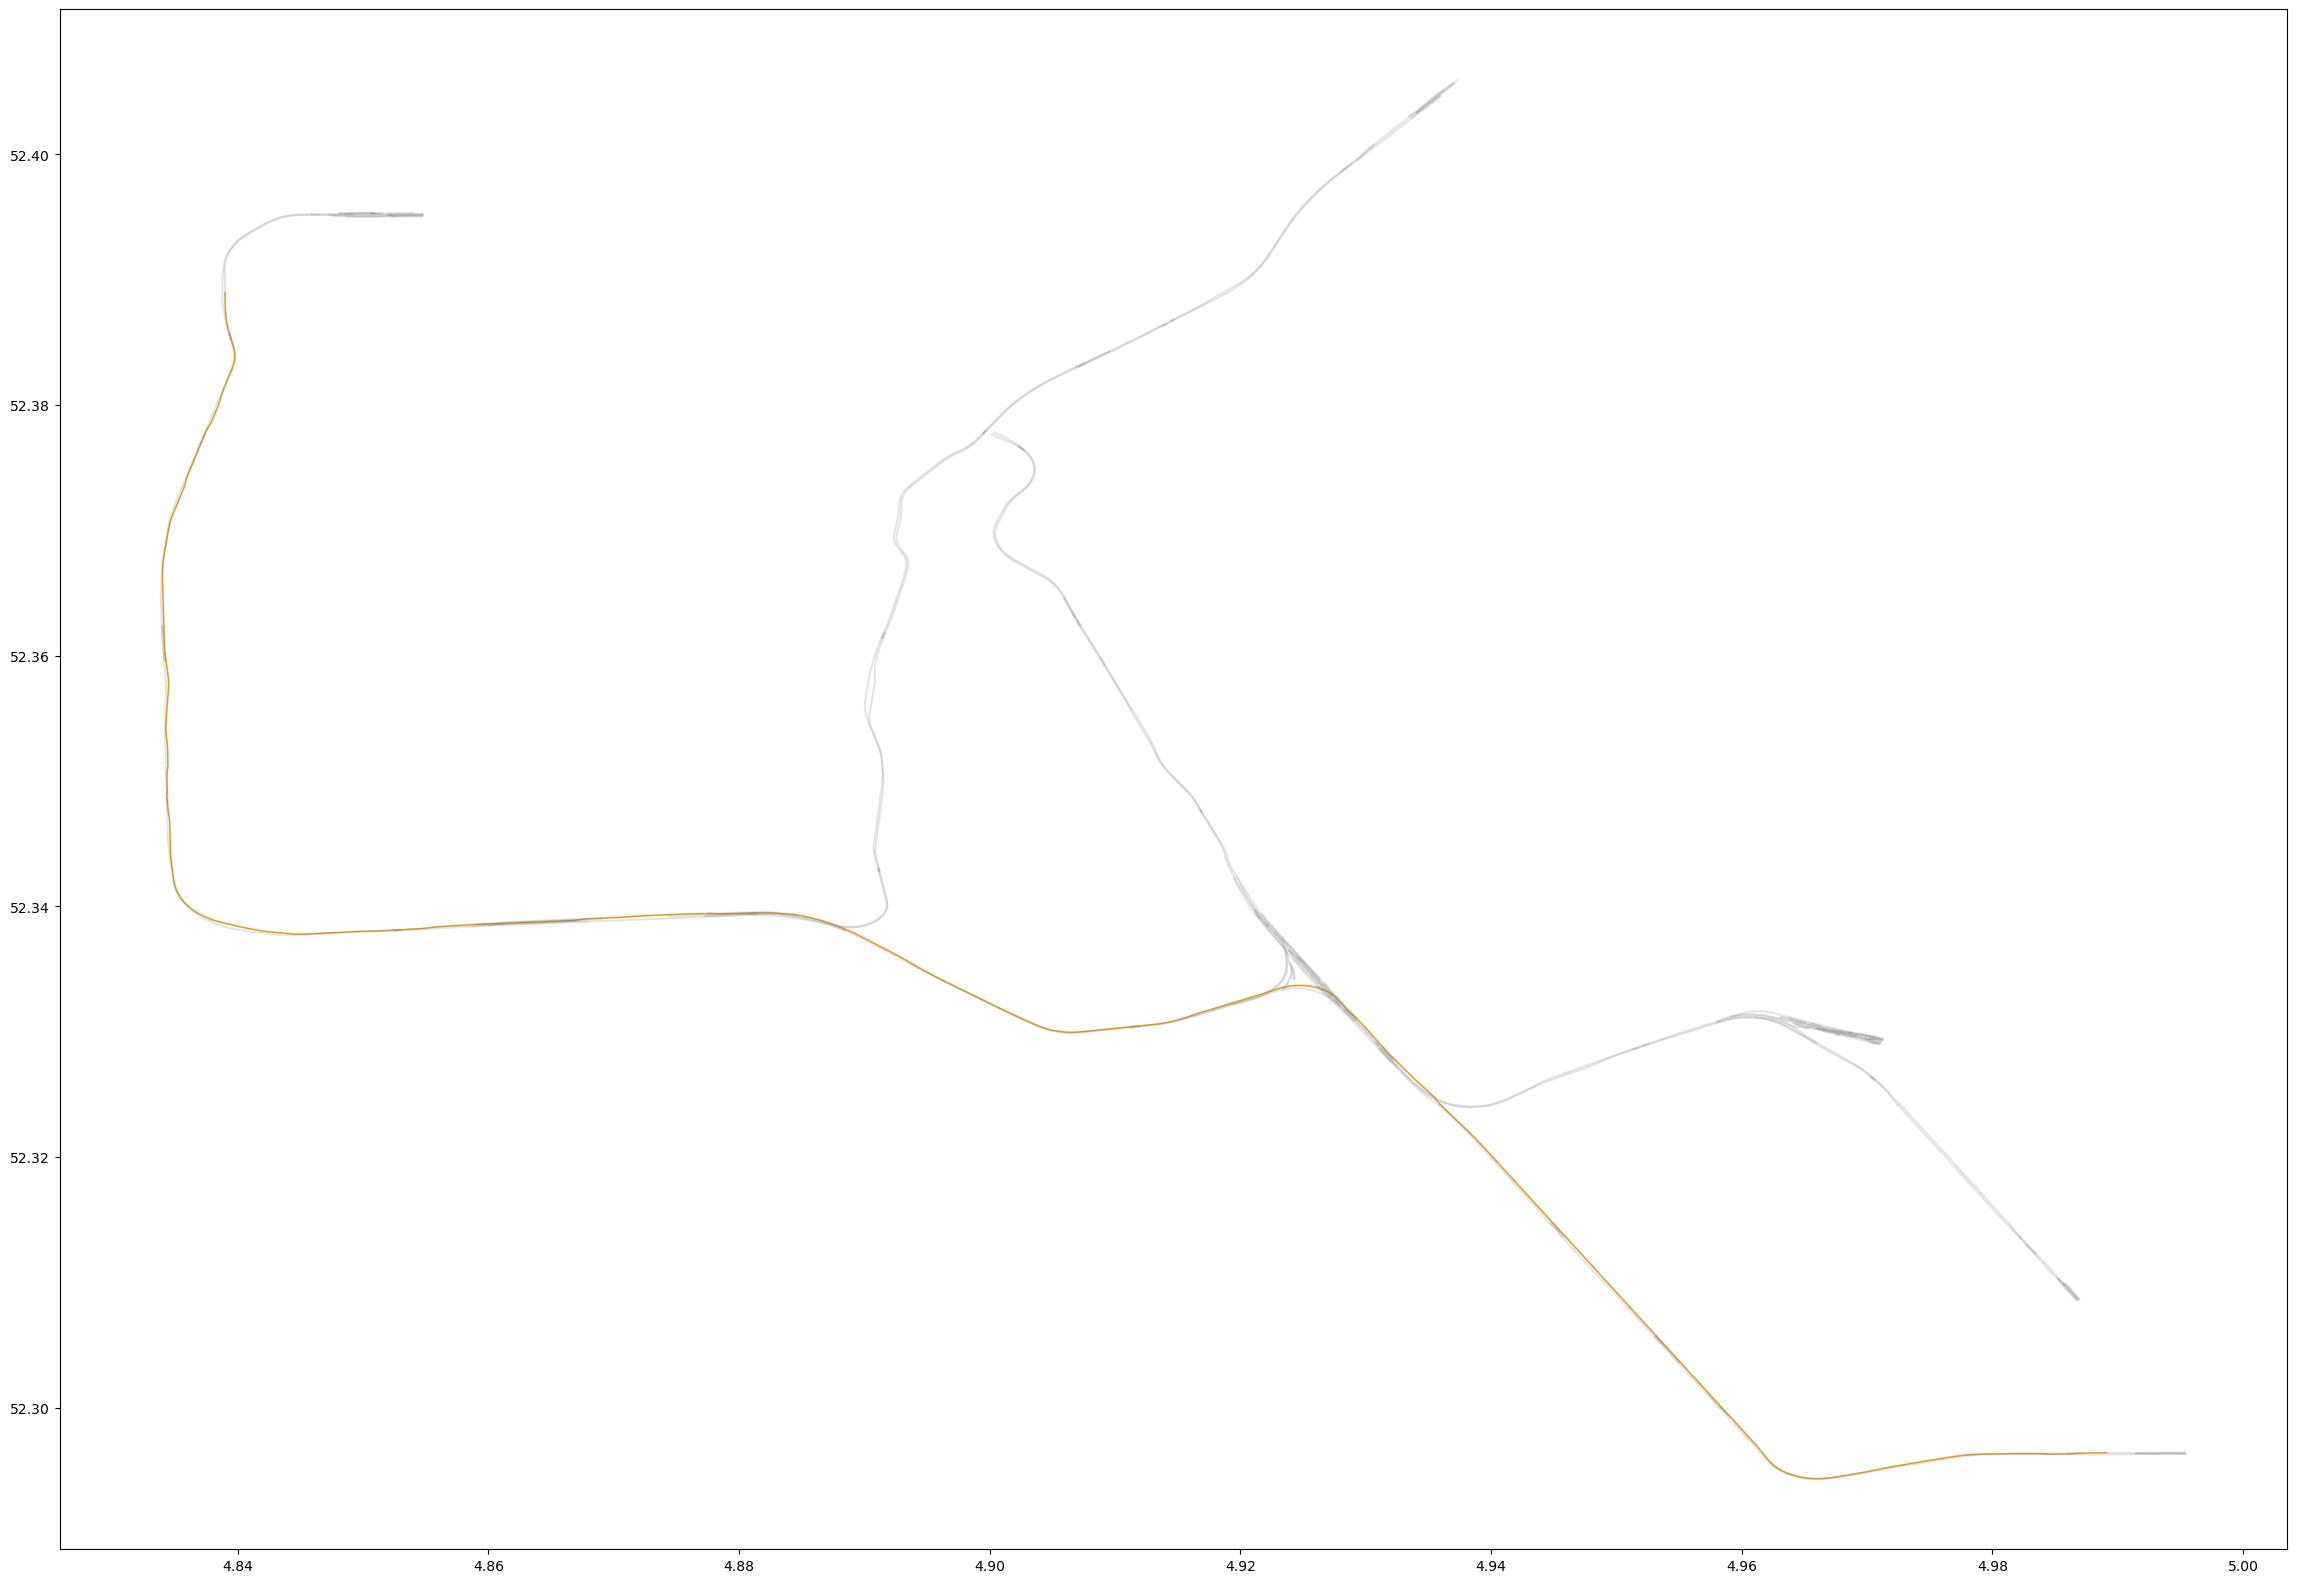

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(30, 20))

gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)

gpd.GeoDataFrame(shortest_path_edges_way.copy()).plot(ax=ax, zorder=1, linewidth=(shortest_path_edges_way.count_weight), color='orange')